In [19]:
# Import basic modules
import numpy as np
import pandas as pd
pd.options.display.max_columns = 1000
import matplotlib.pyplot as plt
import seaborn as sns
import os
import category_encoders as ce

In [32]:
# Import learning modules
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn import linear_model, preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from xgboost import XGBRegressor

In [8]:
# For EDA - scatter plots of each independent variable to dependent variable
def scatterplots(columns, y_col, data, ncol=None, figsize=(15,8)) :
    if ncol == None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = y_col, data = data, alpha=0.2)
        ax.set(xlabel=col, ylabel=y_col)
    nsubplots = nrow * ncol
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
        
# For plotting your predictions versus true
def pred_plot(title, y_true, y_pred, figsize=(8,6)):
    sns.set()
    fig, ax = plt.subplots(figsize=(8,6))
    
    ax.scatter(y_true, y_pred, color='b', alpha=0.4, label='predicted')
    ax.plot(y_true, y_true, marker='.', linestyle='-', color='r', label='perfect "model"')

    ax.set_xlabel('true')
    ax.set_ylabel('predicted')
    ax.set_title(title, fontsize=15)
    ax.legend()

    plt.show()
    
# For displaying CV result statistics
def test_stat(model, y_true, y_pred):
    print(model, ": ")
    print("R^2: ", r2_score(y_true, y_pred))
    print("RMSE: ", (mean_squared_error(y_true, y_pred)) ** 0.5)

In [3]:
# Read file
df = pd.read_csv('Data/Written_essay_scores_cleaned.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     321 non-null    int64  
 1   Total 1 (%)    321 non-null    float64
 2   Country        321 non-null    object 
 3   PTJ1           321 non-null    int64  
 4   SMK1           321 non-null    int64  
 5   Sex            321 non-null    object 
 6   Age            321 non-null    int64  
 7   Grade          321 non-null    float64
 8   Major          321 non-null    object 
 9   Field          321 non-null    object 
 10  VST            321 non-null    float64
 11  CEFR           321 non-null    object 
 12  INTM           321 non-null    float64
 13  INSM           321 non-null    float64
 14  Primary        321 non-null    float64
 15  Secondary      321 non-null    float64
 16  College        321 non-null    float64
 17  Inschool       321 non-null    float64
 18  Outschool 

In [5]:
df.head()

Unnamed: 0  Total 1 (%) Country  PTJ1  SMK1 Sex  Age  Grade      Major  \
0           0        66.65     CHN   271   219   F   20    2.0        Law   
1           1        72.50     CHN   203   292   F   21    3.0        Law   
2           2        70.00     CHN   238   250   F   20    3.0        Law   
3           3        71.70     CHN   269   230   F   20    2.0  Chemistry   
4           4        76.65     CHN   225   208   M   20    2.0  Chemistry   

                   Field   VST  CEFR  INTM  INSM  Primary  Secondary  College  \
0        Social Sciences  30.0  B1_1  0.00  0.00      2.0       3.63     4.25   
1        Social Sciences  27.0  B1_1  4.17  4.33      2.5       4.00     1.86   
2        Social Sciences  32.0  B1_1  5.17  5.17      3.5       4.25     4.25   
3  Sciences & Technology  37.0  B1_2  4.67  5.17      1.0       2.75     4.25   
4  Sciences & Technology  44.0  B1_2  5.17  5.33      2.0       3.63     4.88   

   Inschool  Outschool  Listening  Reading  Speaking  Writing   NS  \
0      3.89       3.56       4.00     4.50      3.50     3.75  4.0   
1      3.00       2.88       3.00     3.00      2.75     3.33  3.0   
2      4.22       4.11       5.00     4.00      3.75     4.25  4.0   
3      3.44       3.00       3.75     3.75      3.25     3.25  3.0   
4      4.33       3.67       5.00     5.00      3.25     3.75  3.0   

   Pronunciation  Presentation  EssayW  Grade_isna   CEE  ONET  TOEIC  \
0            5.0           5.0     4.0           0  72.0   0.0    0.0   
1            3.0           3.0     3.0           0  77.0   0.0    0.0   
2            5.0           5.0     5.0           0  79.0   0.0    0.0   
3            5.0           5.0     5.0           0  87.0   0.0    0.0   
4            5.0           5.0     5.0           0  84.0   0.0    0.0   

   CEE_isna  ONET_isna  TOEIC_isna  
0         0          1           1  
1         0          1           1  
2         0          1           1  
3         0          1           1  
4         0          1           1

In [6]:
df.columns

Index(['Unnamed: 0', 'Total 1 (%)', 'Country', 'PTJ1', 'SMK1', 'Sex', 'Age',
       'Grade', 'Major', 'Field', 'VST', 'CEFR', 'INTM', 'INSM', 'Primary',
       'Secondary', 'College', 'Inschool', 'Outschool', 'Listening', 'Reading',
       'Speaking', 'Writing', 'NS', 'Pronunciation', 'Presentation', 'EssayW',
       'Grade_isna', 'CEE', 'ONET', 'TOEIC', 'CEE_isna', 'ONET_isna',
       'TOEIC_isna'],
      dtype='object')

In [7]:
# Drop Total 2 (Weighted %) - it's a competing target variable.
df = df.drop(['Unnamed: 0'], axis=1)

In [9]:
ptransform = PowerTransformer()

for col in ['PTJ1', 'SMK1']:
    ptransform.fit(df[[col]])
    df[col] = ptransform.transform(df[[col]])

In [10]:
scaler = MinMaxScaler()

for col in ['CEE', 'ONET', 'TOEIC']:
    scaler.fit(df[[col]])
    df[col] = scaler.transform(df[[col]])

In [12]:
# Subset X and y.
X = df.drop(['Total 1 (%)'], axis=1).copy()
y = df['Total 1 (%)'].copy()

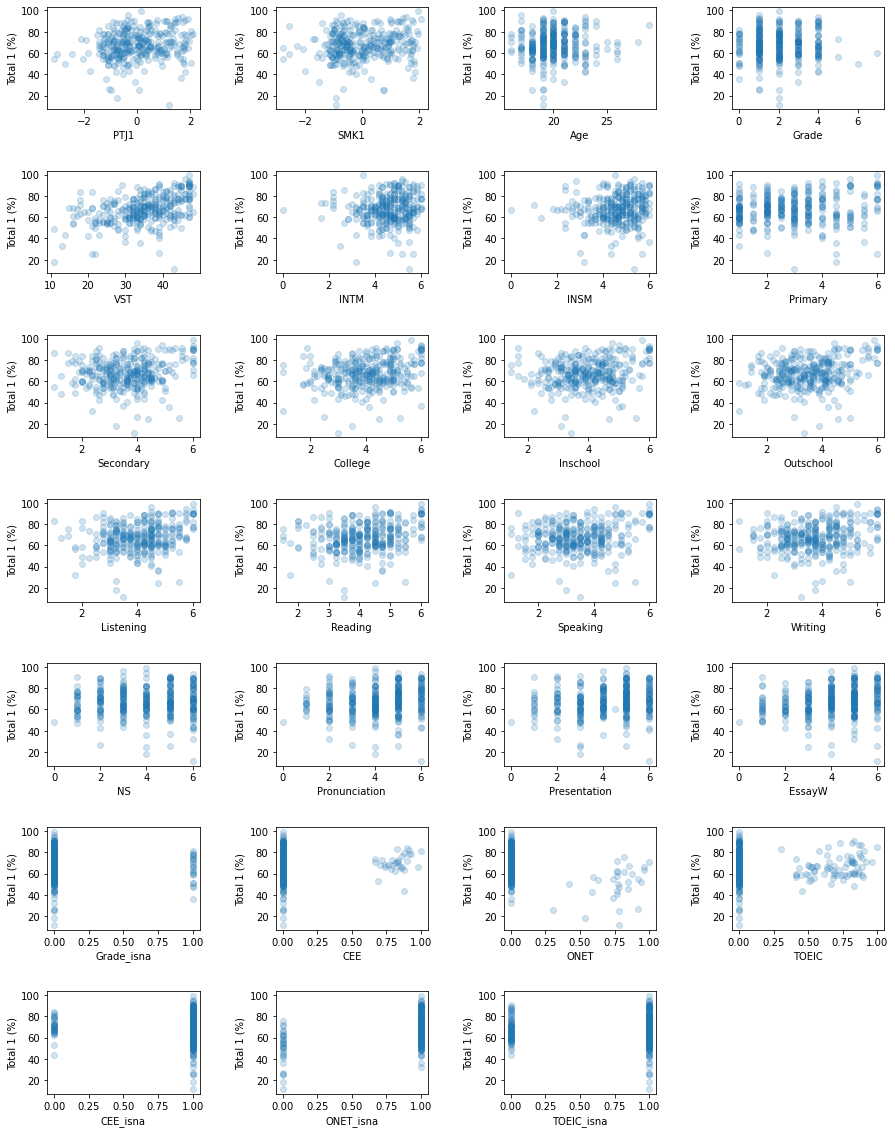

In [14]:
# EDA - plotted
scatterplots(columns = X.select_dtypes(include=np.number).columns, y_col = 'Total 1 (%)', data=df, ncol=4, figsize=(15, 20))

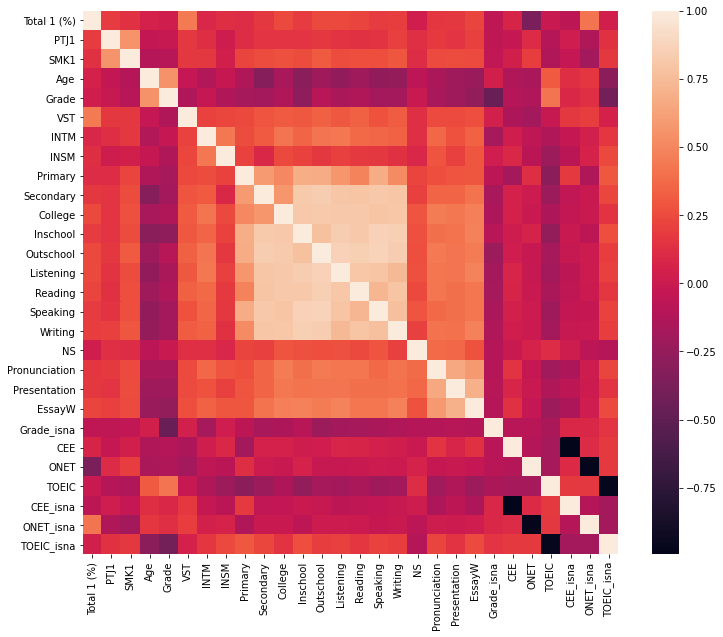

In [15]:
# Also EDA - heatmap
_ = plt.subplots(figsize=(12,10))
_ = sns.heatmap(df.corr())

In [16]:
df.columns

Index(['Total 1 (%)', 'Country', 'PTJ1', 'SMK1', 'Sex', 'Age', 'Grade',
       'Major', 'Field', 'VST', 'CEFR', 'INTM', 'INSM', 'Primary', 'Secondary',
       'College', 'Inschool', 'Outschool', 'Listening', 'Reading', 'Speaking',
       'Writing', 'NS', 'Pronunciation', 'Presentation', 'EssayW',
       'Grade_isna', 'CEE', 'ONET', 'TOEIC', 'CEE_isna', 'ONET_isna',
       'TOEIC_isna'],
      dtype='object')

In [20]:
ce_hash = ce.HashingEncoder(cols=['Major'])
X = ce_hash.fit_transform(X)

C:\Users\jaeyo\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [21]:
# Get dummies
X = pd.get_dummies(X, dtype='int64')
X.shape

(321, 56)

In [22]:
X.head()

col_0  col_1  col_2  col_3  col_4  col_5  col_6  col_7      PTJ1      SMK1  \
0      0      1      0      0      0      0      0      0  1.261177 -0.064936   
1      0      1      0      0      0      0      0      0 -1.225427  1.714323   
2      0      1      0      0      0      0      0      0  0.407529  0.982605   
3      0      0      0      0      0      1      0      0  1.221073  0.382433   
4      0      0      0      0      0      1      0      0 -0.080849 -0.629511   

   Age  Grade   VST  INTM  INSM  Primary  Secondary  College  Inschool  \
0   20    2.0  30.0  0.00  0.00      2.0       3.63     4.25      3.89   
1   21    3.0  27.0  4.17  4.33      2.5       4.00     1.86      3.00   
2   20    3.0  32.0  5.17  5.17      3.5       4.25     4.25      4.22   
3   20    2.0  37.0  4.67  5.17      1.0       2.75     4.25      3.44   
4   20    2.0  44.0  5.17  5.33      2.0       3.63     4.88      4.33   

   Outschool  Listening  Reading  Speaking  Writing   NS  Pronunciation  \
0       3.56       4.00     4.50      3.50     3.75  4.0            5.0   
1       2.88       3.00     3.00      2.75     3.33  3.0            3.0   
2       4.11       5.00     4.00      3.75     4.25  4.0            5.0   
3       3.00       3.75     3.75      3.25     3.25  3.0            5.0   
4       3.67       5.00     5.00      3.25     3.75  3.0            5.0   

   Presentation  EssayW  Grade_isna       CEE  ONET  TOEIC  CEE_isna  \
0           5.0     4.0           0  0.742268   0.0    0.0         0   
1           3.0     3.0           0  0.793814   0.0    0.0         0   
2           5.0     5.0           0  0.814433   0.0    0.0         0   
3           5.0     5.0           0  0.896907   0.0    0.0         0   
4           5.0     5.0           0  0.865979   0.0    0.0         0   

   ONET_isna  TOEIC_isna  Country_CHN  Country_HKG  Country_IDN  Country_JPN  \
0          1           1            1            0            0            0   
1          1           1            1            0            0            0   
2          1           1            1            0            0            0   
3          1           1            1            0            0            0   
4          1           1            1            0            0            0   

   Country_KOR  Country_PAK  Country_PHL  Country_SIN  Country_THA  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Country_TWN  Sex_F  Sex_M  Field_Humanities  Field_Life Sciences  \
0            0      1      0                 0                    0   
1            0      1      0                 0                    0   
2            0      1      0                 0                    0   
3            0      1      0                 0                    0   
4            0      0      1                 0                    0   

   Field_Other  Field_Sciences & Technology  Field_Social Sciences  CEFR_A2_0  \
0            0                            0                      1          0   
1            0                            0                      1          0   
2            0                            0                      1          0   
3            0                            1                      0          0   
4            0                            1                      0          0   

   CEFR_B1_1  CEFR_B1_2  CEFR_B2_0  
0          1          0          0  
1          1          0          0  
2          1          0          0  
3          0          1          0  
4          0          1          0

In [25]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(type(X_train), type(X_test), type(y_train), type(y_test))

(240, 56) (81, 56) (240,) (81,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [38]:
# Pipeline for linear regression, for selecting best number of features to feed into linreg
pipe = make_pipeline(StandardScaler(), SelectKBest(f_regression), LinearRegression())
params = {
    'standardscaler' : [StandardScaler(), None],
    'selectkbest__k' : [n+1 for n in range(len(X_train))],
}

# 3-fold CV, cross-validation scores
lr_grid_cv = GridSearchCV(pipe, params, cv=3, n_jobs=-1)
lr_grid_cv.fit(X_train, y_train)
print(lr_grid_cv.best_params_)
pd.DataFrame(lr_grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

{'selectkbest__k': 7, 'standardscaler': None}


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.13457376 0.13457376 0.20253753 0.20253753 0.22024005 0.22024005
 0.3536026  0.3536026  0.38383738 0.38383738 0.38519303 0.38519303
 0.39012797 0.39012797 0.3710938  0.3710938  0.38357153 0.38357153
 0.38266365 0.38266365 0.37631296 0.37631296 0.3671394  0.3671394
 0.34785545 0.34785545 0.33344477 0.33344477 0.32980243 0.32980243
 0.32719787 0.32719787 0.32973134 0.32973134 0.33022459 0.33022459
 0.33532991 0.33532991 0.35034975 0.35034975 0.33980038 0.33980038
 0.30025481 0.30025481 0.2962933  0.2962933  0.28427218 0.28427218
 0.28369243 0.28369243 0.28545446 0.28545446 0.28890889 0.28890889
 0.29055817 0.29055817 0.28383904 0.28383904 0.27628539 0.27628539
 0.27281348 0.27281348 0.26133199 0.26133199 0.26209808 0.26209808
 0.259202   0.259202   0.2546213  0.2546213  0.27118978 0.27118978
 0.26434845 0.26434845 0.25393052 0.25393052 0.2551801

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
13       0.006649  4.696855e-04         0.002659    4.701342e-04   
12       0.007979  5.840039e-07         0.003326    4.689624e-04   
10       0.008975  3.326487e-06         0.002990    1.766373e-06   
11       0.008310  4.688416e-04         0.002993    2.973602e-07   
9        0.008642  1.243606e-03         0.003324    4.703588e-04   

   param_selectkbest__k param_standardscaler  \
13                    7                 None   
12                    7     StandardScaler()   
10                    6     StandardScaler()   
11                    6                 None   
9                     5                 None   

                                               params  split0_test_score  \
13      {'selectkbest__k': 7, 'standardscaler': None}           0.237016   
12  {'selectkbest__k': 7, 'standardscaler': Standa...           0.237016   
10  {'selectkbest__k': 6, 'standardscaler': Standa...           0.231475   
11      {'selectkbest__k': 6, 'standardscaler': None}           0.231475   
9       {'selectkbest__k': 5, 'standardscaler': None}           0.230532   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
13           0.557034           0.376334         0.390128        0.131010   
12           0.557034           0.376334         0.390128        0.131010   
10           0.556209           0.367895         0.385193        0.133135   
11           0.556209           0.367895         0.385193        0.133135   
9            0.553045           0.367935         0.383837        0.132144   

    rank_test_score  
13                1  
12                2  
10                3  
11                4  
9                 5

In [43]:
lr_cv = pd.DataFrame(lr_grid_cv.cv_results_)

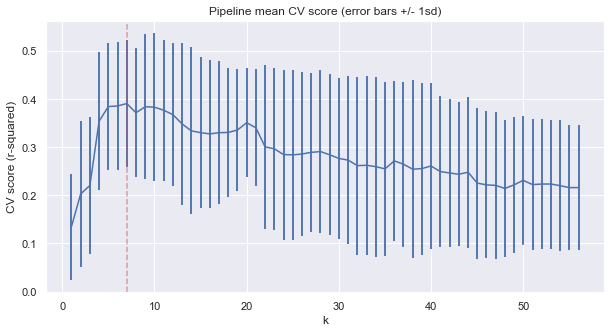

In [44]:
# Visually plotting best number of k's
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(lr_cv.param_selectkbest__k, lr_cv.mean_test_score, yerr=lr_cv.std_test_score)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [46]:
# Optimal columns for best linreg fit: selected
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
X_train.columns[selected]

Index(['VST', 'ONET', 'ONET_isna', 'Country_SIN', 'Country_THA', 'CEFR_A2_0',
       'CEFR_B2_0'],
      dtype='object')

In [47]:
# Coefficients of regression: coefs; column names: features
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

ONET           44.142382
ONET_isna      25.331690
Country_SIN    13.236565
CEFR_B2_0       2.997607
VST             0.392662
CEFR_A2_0      -1.165377
Country_THA   -25.331690
dtype: float64

In [48]:
lr_best = lr_grid_cv.best_estimator_
lr_best.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', None),
                ('selectkbest',
                 SelectKBest(k=7,
                             score_func=<function f_regression at 0x000001A914150B80>)),
                ('linearregression', LinearRegression())])

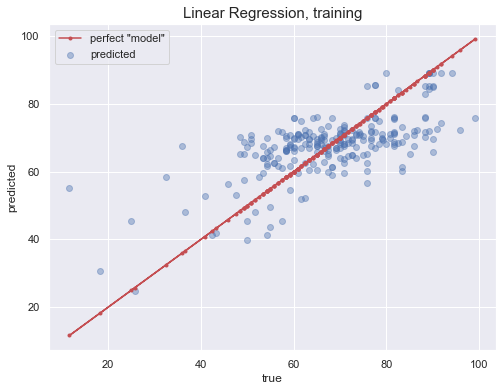

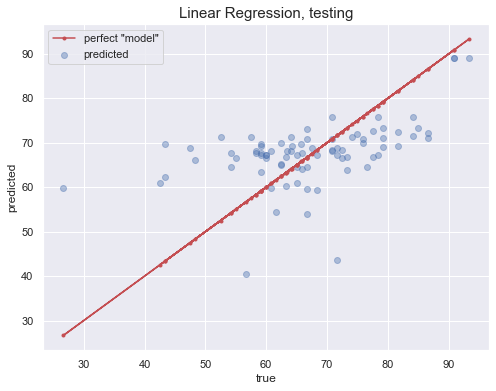

In [49]:
# Predict Training and Test sets with Rf model
y_tr_lr_pred = lr_best.predict(X_train)
y_te_lr_pred = lr_best.predict(X_test)

# Plot predicted vs true
pred_plot("Linear Regression, training", y_train, y_tr_lr_pred)
pred_plot("Linear Regression, testing", y_test, y_te_lr_pred)

In [50]:
# Print test stats
test_stat("Linear Regression", y_test, y_te_lr_pred)

Linear Regression : 
R^2:  0.23087161340804674
RMSE:  10.36041983693667


In [52]:
# Random Forest Regressor - initialize
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Parameter grid for gridsearch
params = {
    'n_estimators': [int(n) for n in np.logspace(2,3,5)],
    'max_depth': [None, 10, 20, 30]
}

# 3-fold CV Grid Search, fit, and show top five CV stats.
rf_grid_cv = GridSearchCV(rf, params, cv=3, n_jobs=-1)
rf_grid_cv.fit(X_train, y_train)
print(rf_grid_cv.best_params_)
pd.DataFrame(rf_grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

{'max_depth': 10, 'n_estimators': 316}


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
7        0.986255      0.086736         0.066991        0.010911   
2        0.829424      0.027454         0.060331        0.006846   
17       0.890790      0.071496         0.099848        0.021423   
12       0.859526      0.147418         0.059429        0.007825   
6        0.471511      0.014670         0.047876        0.009452   

   param_max_depth param_n_estimators  \
7               10                316   
2             None                316   
17              30                316   
12              20                316   
6               10                177   

                                      params  split0_test_score  \
7     {'max_depth': 10, 'n_estimators': 316}           0.214164   
2   {'max_depth': None, 'n_estimators': 316}           0.208018   
17    {'max_depth': 30, 'n_estimators': 316}           0.208018   
12    {'max_depth': 20, 'n_estimators': 316}           0.208018   
6     {'max_depth': 10, 'n_estimators': 177}           0.208681   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
7            0.529492           0.344926         0.362861        0.129355   
2            0.531388           0.343641         0.361016        0.132586   
17           0.531388           0.343641         0.361016        0.132586   
12           0.531353           0.343569         0.360980        0.132574   
6            0.525553           0.340472         0.358235        0.129971   

    rank_test_score  
7                 1  
2                 2  
17                2  
12                4  
6                 5

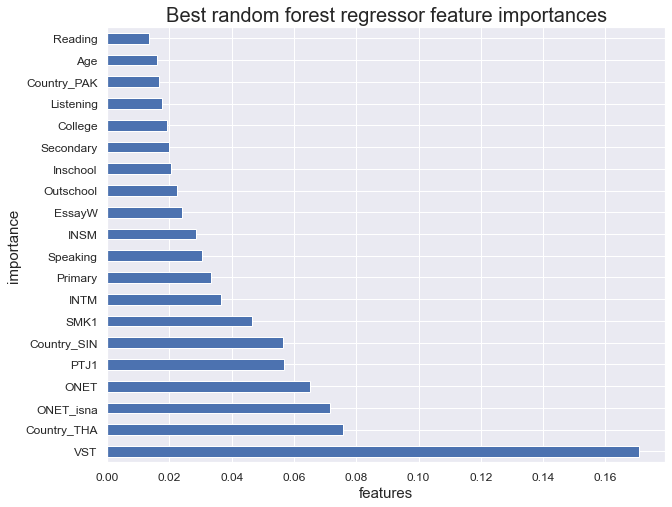

In [53]:
# Manually store best RF estimator as rf_best. Fit to training set.
rf_best = RandomForestRegressor(random_state=42, max_depth=10, n_estimators=316, n_jobs=-1)
rf_best.fit(X_train, y_train)

# Plot the top 20 feature importances.
plt.subplots(figsize=(10, 8))
imps = rf_best.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)[:20]
_ = rf_feat_imps.plot(kind='barh', fontsize=12)
_ = plt.xlabel('features', fontsize=15)
_ = plt.ylabel('importance', fontsize=15)
_ = plt.title('Best random forest regressor feature importances', fontsize=20);
plt.show()

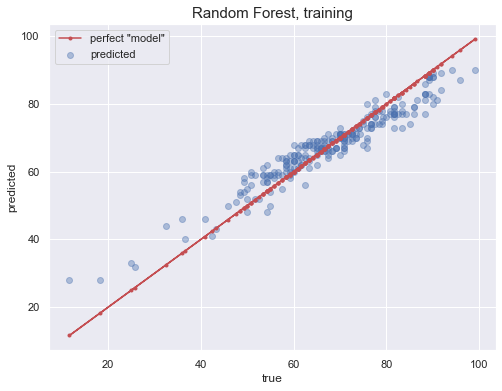

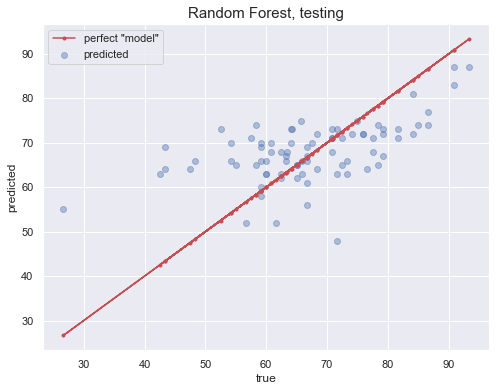

In [54]:
# Predict Training and Test sets with Rf model
y_tr_rf_pred = rf_best.predict(X_train)
y_te_rf_pred = rf_best.predict(X_test)

# Plot predicted vs true
pred_plot("Random Forest, training", y_train, np.round(y_tr_rf_pred))
pred_plot("Random Forest, testing", y_test, np.round(y_te_rf_pred))

In [55]:
# Print test stats
test_stat("Random Forest", y_test, y_te_rf_pred)

Random Forest : 
R^2:  0.30834264261956834
RMSE:  9.824793591605438


In [57]:
# XG Boost - initialize.
xg = XGBRegressor(objective='reg:linear', seed=42)
xgb.set_config(verbosity=0)

# Parameter grid for grid searching.
params = {
    'max_depth': range(2, 9),
    'n_estimators': [int(n) for n in np.logspace(start=2, stop=3, num=5)],
    'learning_rate': [n for n in np.logspace(start=-3, stop=0, num=4)]
}

# 3-fold CV Grid search, fit, and print CV stats for top five estimators
xg_grid_cv = GridSearchCV(xg, params, cv=3, n_jobs=-1)
xg_grid_cv.fit(X_train, y_train)
print(xg_grid_cv.best_params_)
pd.DataFrame(xg_grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 562}


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
38       0.634970      0.008970         0.003989    1.946680e-07   
39       1.280912      0.052329         0.004652    4.682801e-04   
43       1.010633      0.018681         0.004658    4.730203e-04   
70       0.108376      0.003084         0.003989    1.946680e-07   
44       1.656905      0.037506         0.004322    4.704714e-04   

   param_learning_rate param_max_depth param_n_estimators  \
38                0.01               2                562   
39                0.01               2               1000   
43                0.01               3                562   
70                 0.1               2                100   
44                0.01               3               1000   

                                               params  split0_test_score  \
38  {'learning_rate': 0.01, 'max_depth': 2, 'n_est...           0.233600   
39  {'learning_rate': 0.01, 'max_depth': 2, 'n_est...           0.238273   
43  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...           0.199942   
70  {'learning_rate': 0.1, 'max_depth': 2, 'n_esti...           0.212856   
44  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...           0.188646   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
38           0.522181           0.256380         0.337387        0.130999   
39           0.528643           0.209100         0.325339        0.144250   
43           0.529487           0.241146         0.323525        0.146606   
70           0.526439           0.191725         0.310340        0.153049   
44           0.510901           0.227585         0.309044        0.143617   

    rank_test_score  
38                1  
39                2  
43                3  
70                4  
44                5

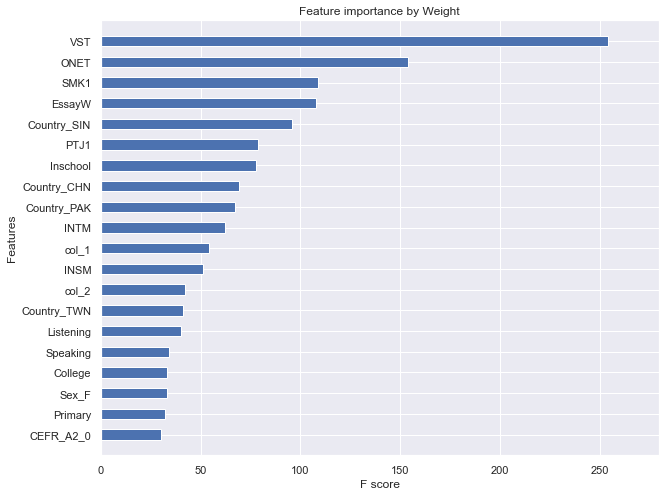

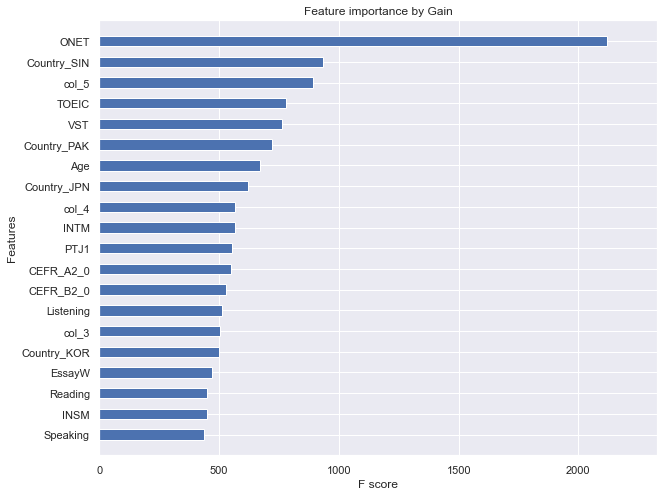

In [58]:
# Manually store best XG Boost model as xg_best. Fit to training set.
xg_best = XGBRegressor(objective='reg:linear', learning_rate=0.01, max_depth=2, n_estimators=562, seed=42)
xg_best.fit(X_train, y_train)

# Plot top 20 feature importances of XG Boost model. Importance type 'weight' and 'gain' show completely different results. Plot both
fig, ax = plt.subplots(figsize=(10,8))
xgb.plot_importance(xg_best, importance_type = 'weight', ax=ax, title='Feature importance by Weight', 
                    height=0.5, max_num_features=20, show_values=False)
plt.show()

fig, ax = plt.subplots(figsize=(10,8))
xgb.plot_importance(xg_best, importance_type = 'gain', ax=ax, title='Feature importance by Gain', 
                    height=0.5, max_num_features=20, show_values=False)
plt.show()

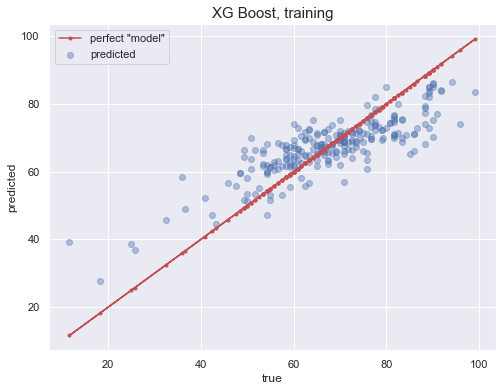

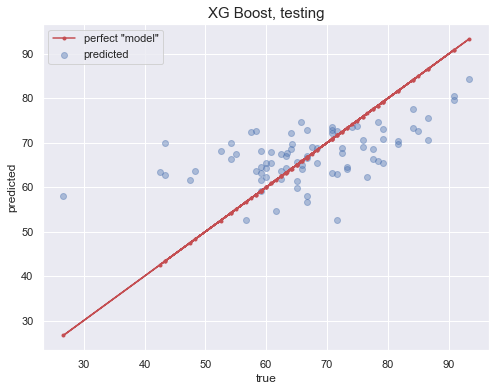

In [88]:
# Predict on Training and Test sets using XG Boost model
y_tr_xg_pred = xg_best.predict(X_train)
y_te_xg_pred = xg_best.predict(X_test)

# Plot predicted vs true
pred_plot("XG Boost, training", y_train, y_tr_xg_pred)
pred_plot("XG Boost, testing", y_test, y_te_xg_pred)

In [60]:
# Print test stats
test_stat("XG Boost", y_test, y_te_xg_pred)

XG Boost : 
R^2:  0.29267870599660073
RMSE:  9.935421605733593


In [62]:
# Initialize pipeline for optional StandardScaler followed by Lasso regression
scaler = StandardScaler()
lasso = Lasso(random_state=42)
pipe = make_pipeline(scaler, lasso)

# Parameter grid for pipeline - scaler is optional.
params = {
    'standardscaler': [StandardScaler(), None],
    'lasso__alpha': [n for n in np.logspace(-6,3,21)],
    'lasso__max_iter': [1000, 3000, 10000]
}

# 3-fold CV Grid Search, fit, and print CV test results for top five estimators. Commented out for run-through
lasso_grid_cv = GridSearchCV(pipe, params, cv=3, n_jobs=-1)
lasso_grid_cv.fit(X_train, y_train)
print(lasso_grid_cv.best_params_)
pd.DataFrame(lasso_grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

{'lasso__alpha': 0.7079457843841388, 'lasso__max_iter': 1000, 'standardscaler': StandardScaler()}


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
82       0.006715  4.747871e-03         0.003357        0.004748   
80       0.010079  1.901512e-05         0.003357        0.004748   
78       0.005358  3.788672e-03         0.004726        0.003804   
88       0.010071  9.199649e-07         0.000000        0.000000   
84       0.008038  7.393112e-06         0.002033        0.000008   

   param_lasso__alpha param_lasso__max_iter param_standardscaler  \
82           0.707946                 10000     StandardScaler()   
80           0.707946                  3000     StandardScaler()   
78           0.707946                  1000     StandardScaler()   
88           1.995262                 10000     StandardScaler()   
84           1.995262                  1000     StandardScaler()   

                                               params  split0_test_score  \
82  {'lasso__alpha': 0.7079457843841388, 'lasso__m...           0.276706   
80  {'lasso__alpha': 0.7079457843841388, 'lasso__m...           0.276706   
78  {'lasso__alpha': 0.7079457843841388, 'lasso__m...           0.276706   
88  {'lasso__alpha': 1.9952623149688788, 'lasso__m...           0.215905   
84  {'lasso__alpha': 1.9952623149688788, 'lasso__m...           0.215905   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
82           0.552467           0.326539         0.385237        0.119986   
80           0.552467           0.326539         0.385237        0.119986   
78           0.552467           0.326539         0.385237        0.119986   
88           0.457938           0.352853         0.342232        0.099094   
84           0.457938           0.352853         0.342232        0.099094   

    rank_test_score  
82                1  
80                1  
78                1  
88                4  
84                4

In [91]:
lasso_best = lasso_grid_cv.best_estimator_
lasso_best.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.7079457843841388, random_state=42))])

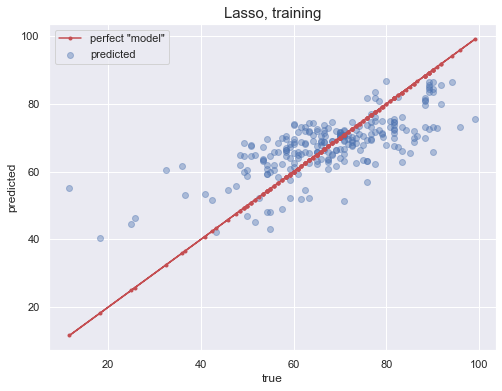

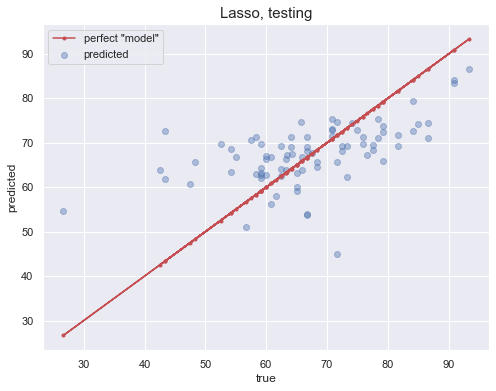

In [92]:
# Predict Testing and Test sets using Lasso regression
y_tr_lasso_pred = lasso_best.predict(X_train)
y_te_lasso_pred = lasso_best.predict(X_test)

# Plot predicted vs true
pred_plot("Lasso, training", y_train, y_tr_lasso_pred)
pred_plot("Lasso, testing", y_test, y_te_lasso_pred)

In [93]:
# Print test stats for Lasso
test_stat("Lasso", y_test, y_te_lasso_pred)

Lasso : 
R^2:  0.31934582886298746
RMSE:  9.7463317432125


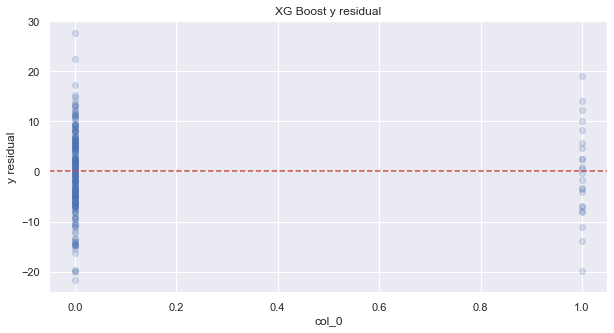

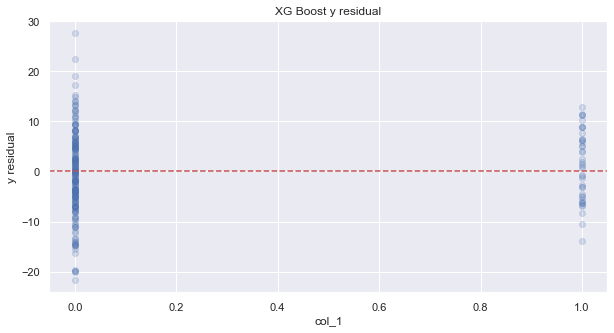

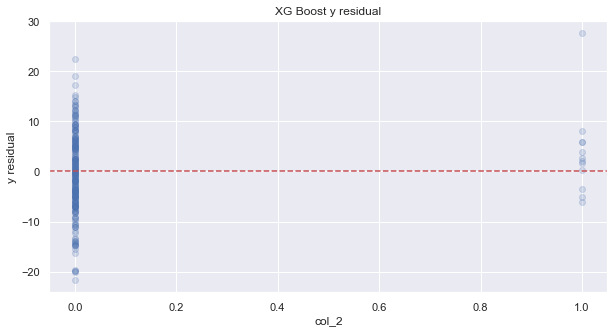

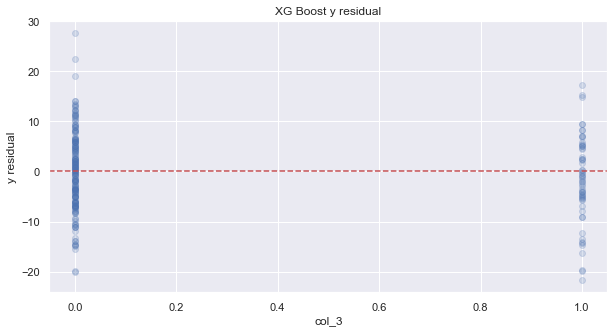

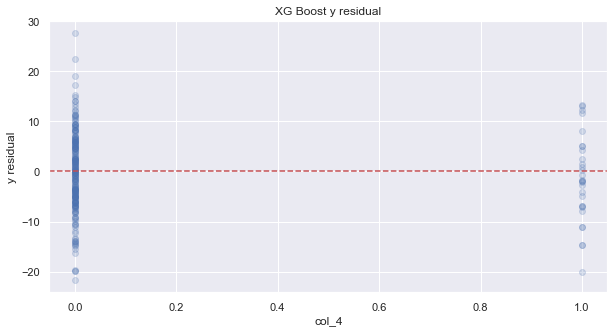

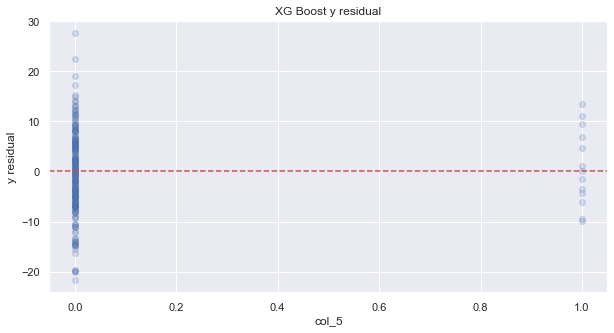

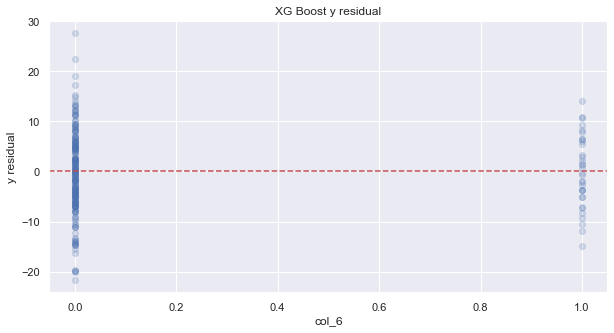

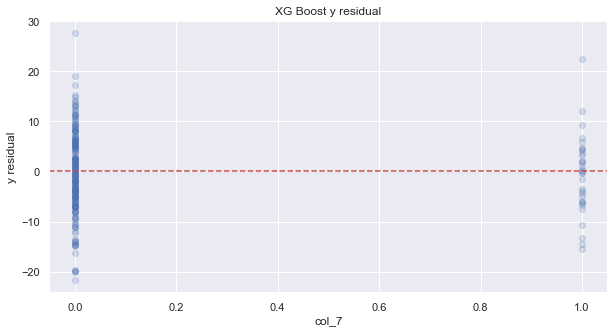

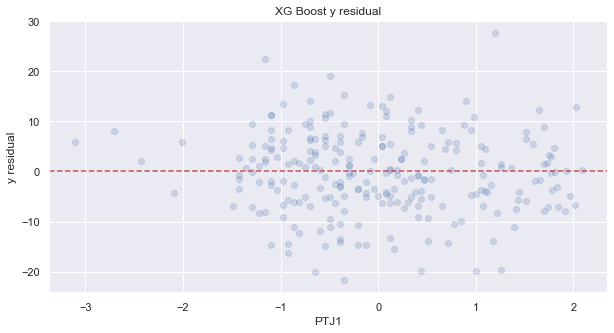

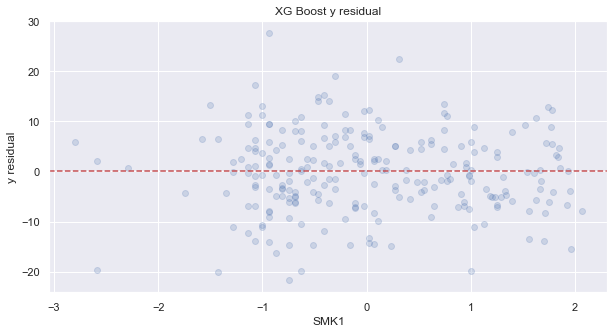

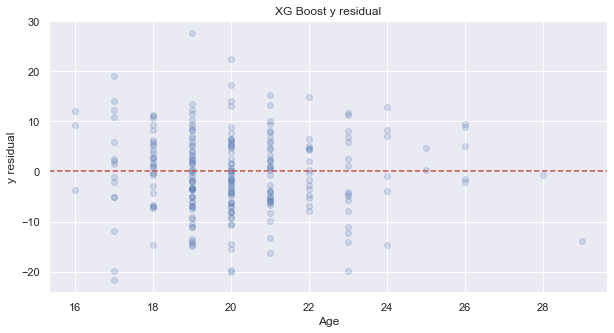

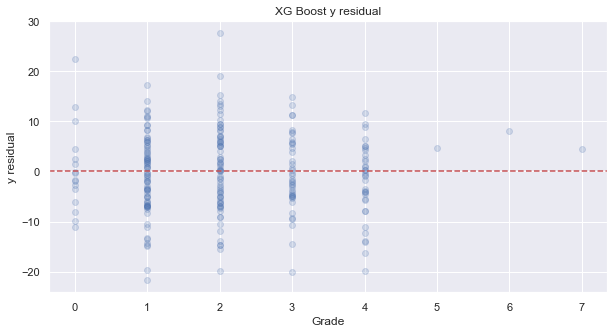

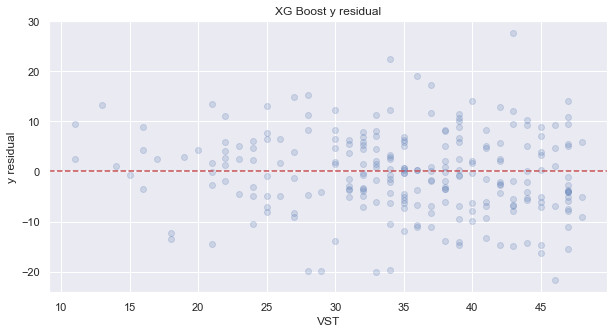

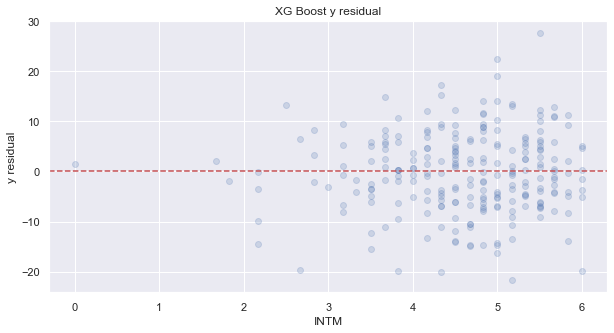

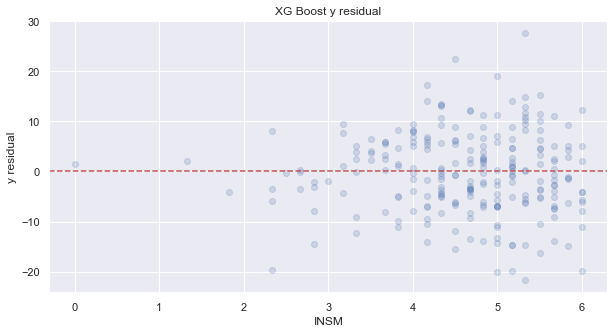

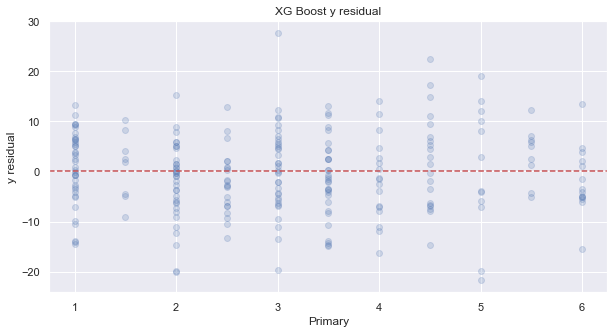

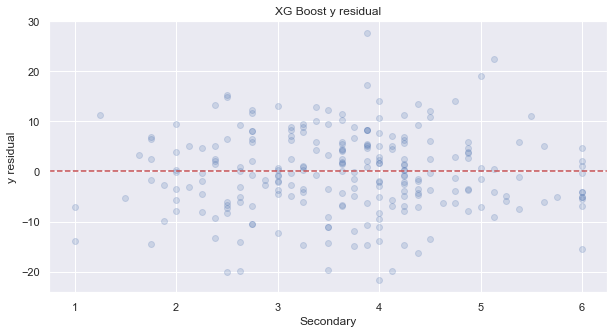

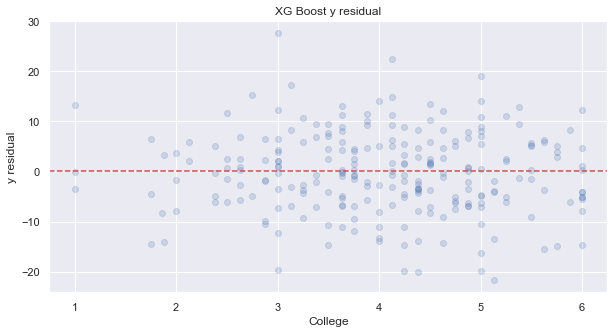

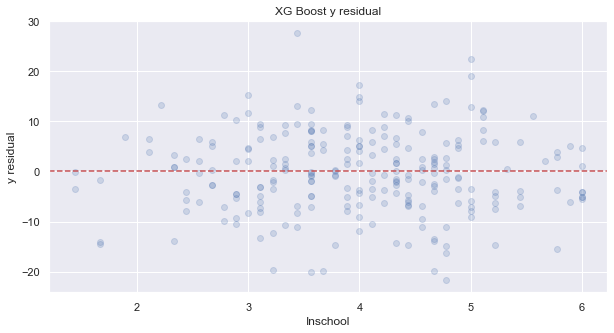

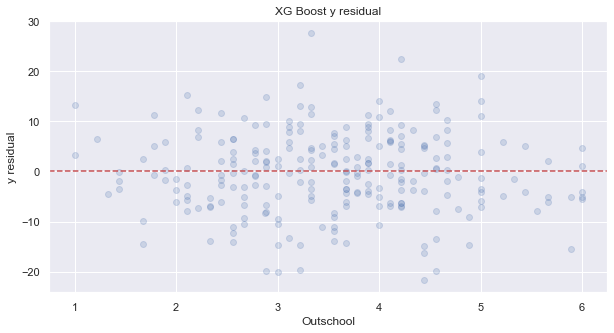

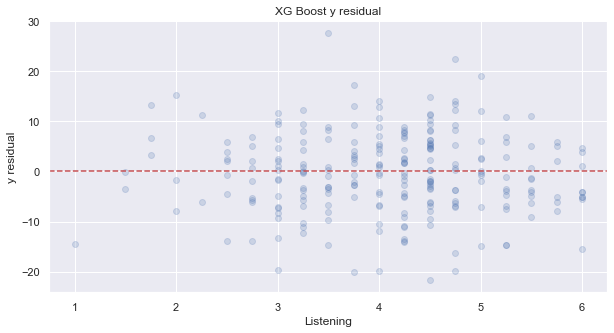

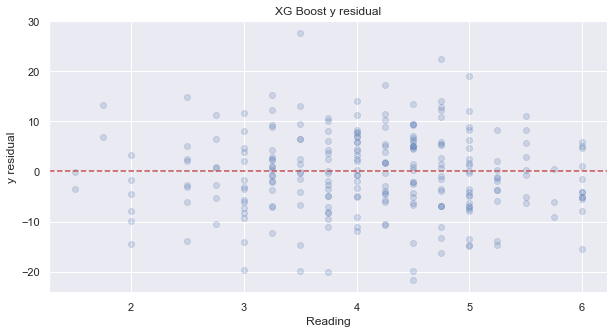

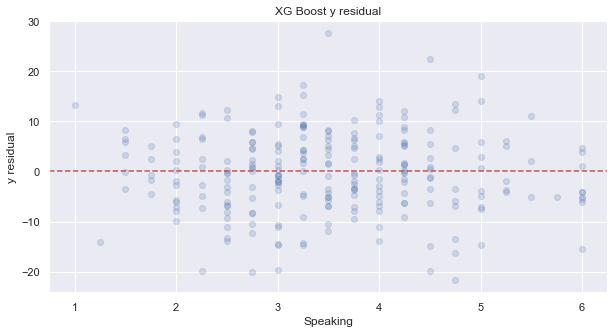

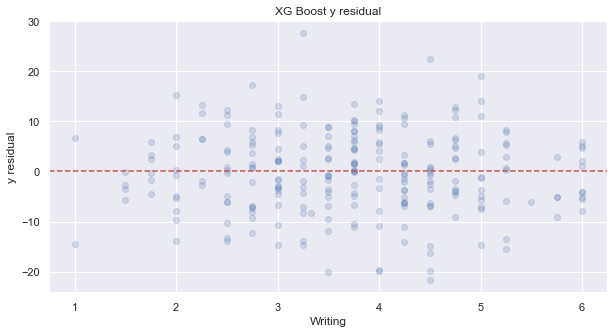

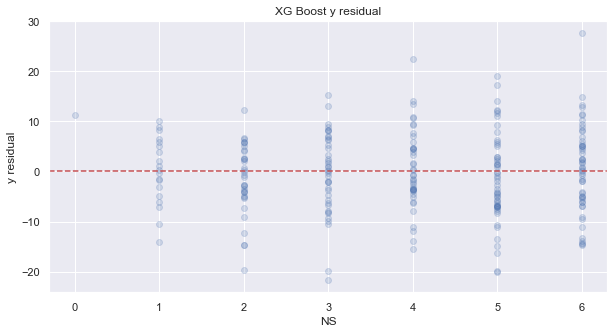

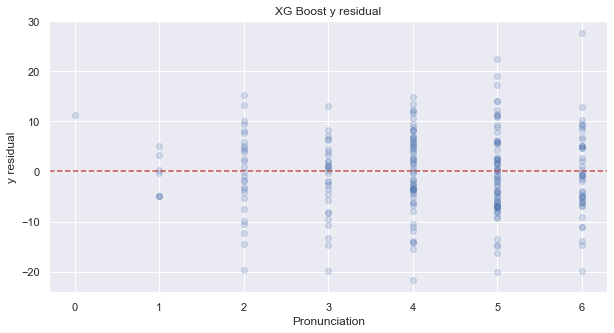

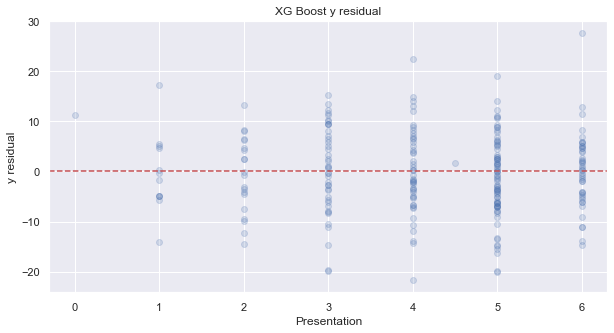

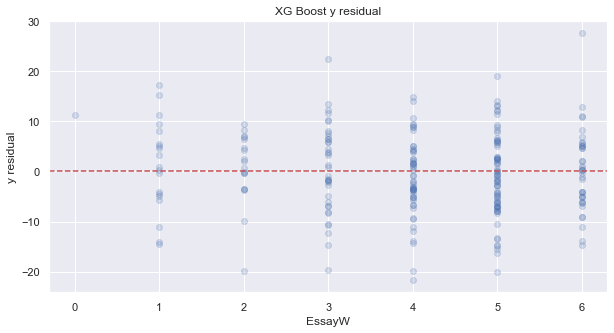

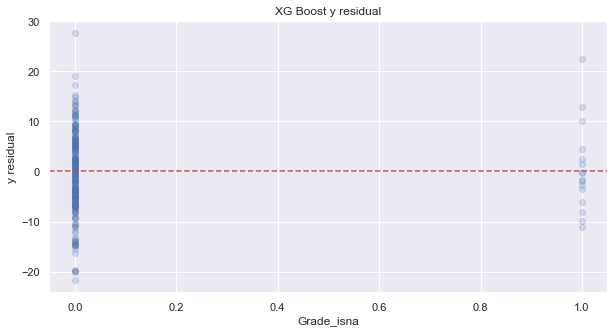

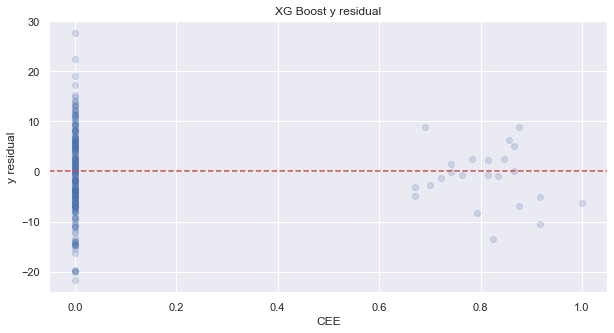

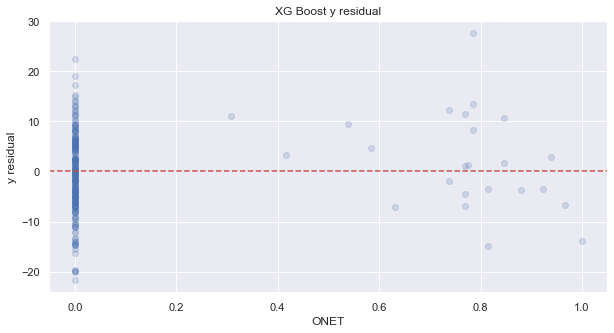

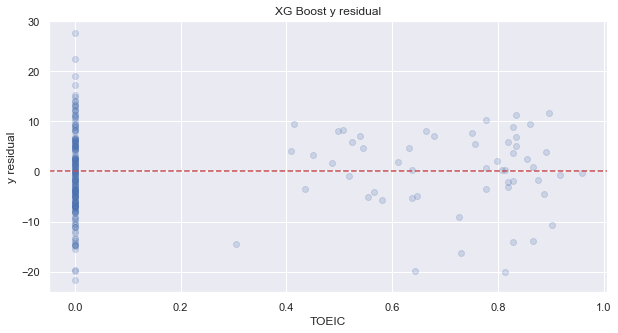

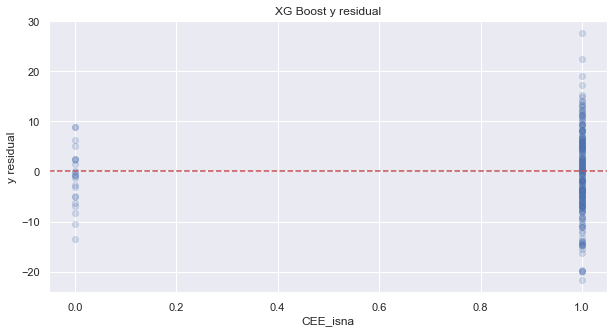

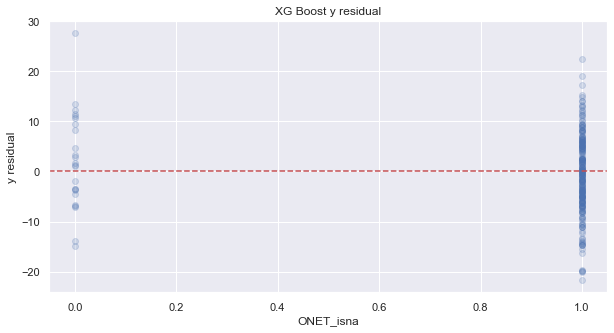

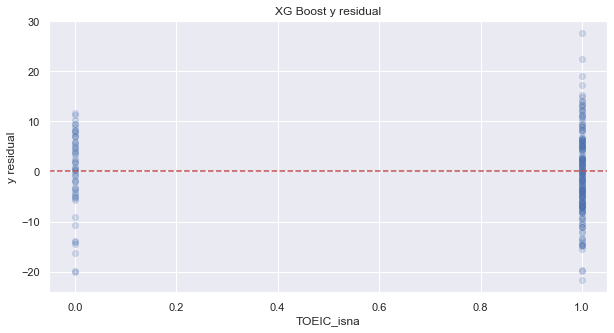

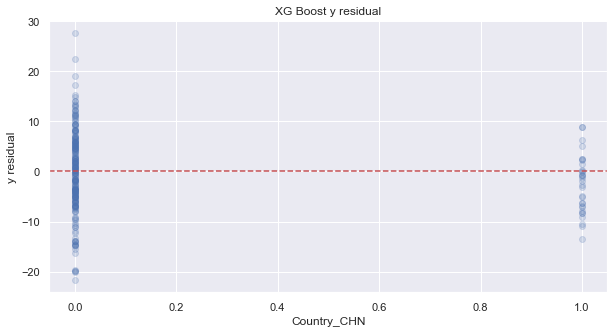

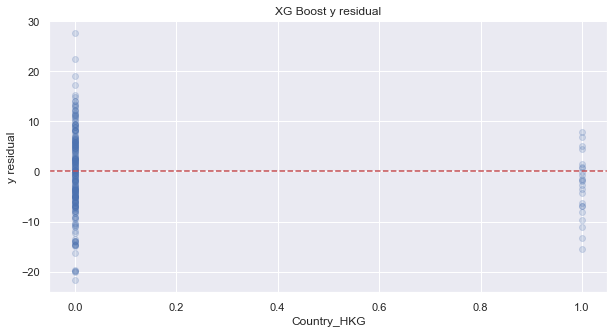

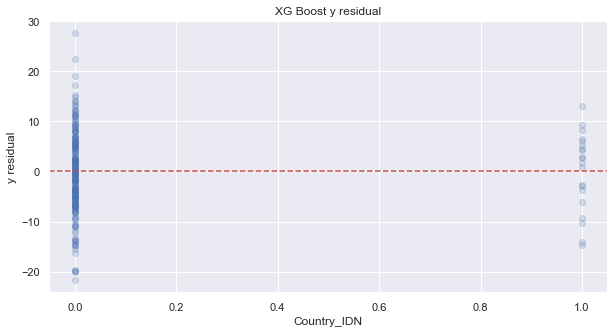

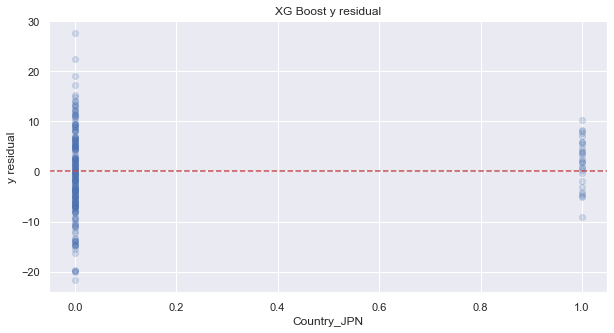

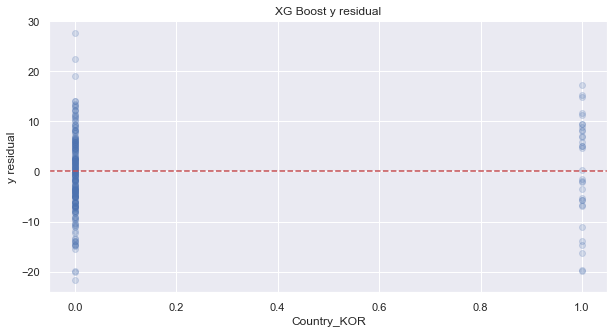

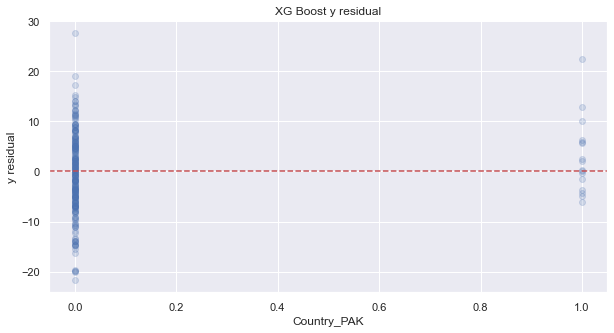

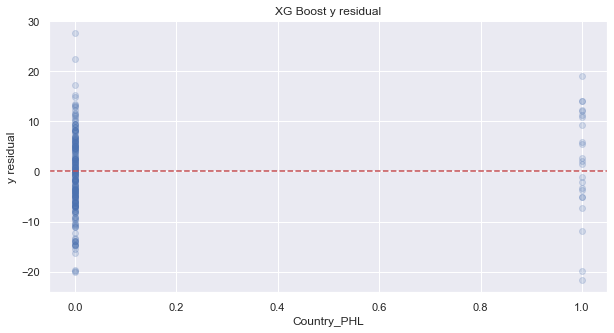

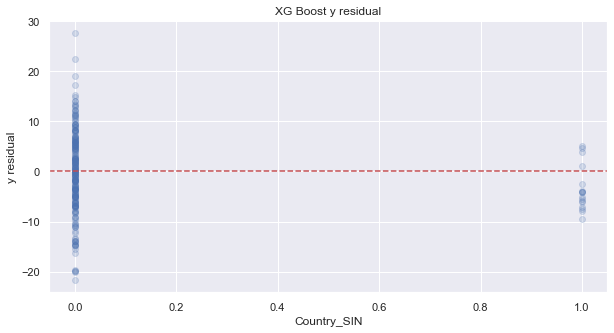

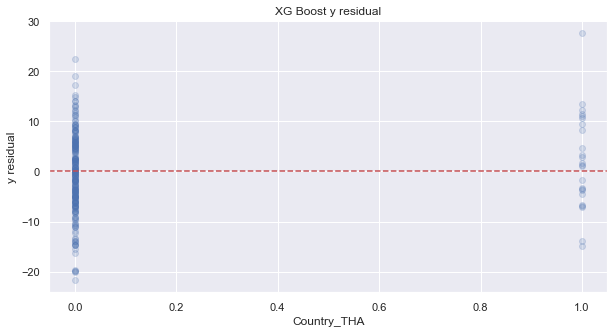

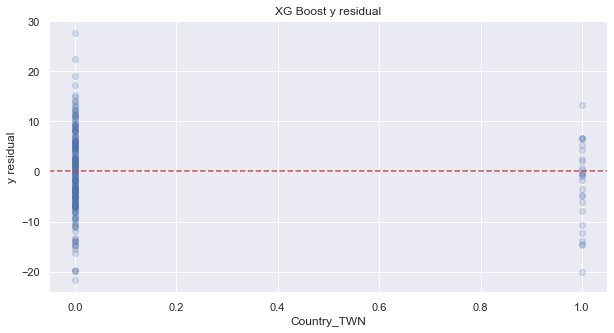

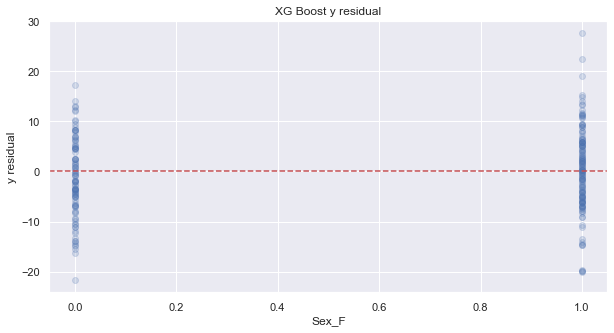

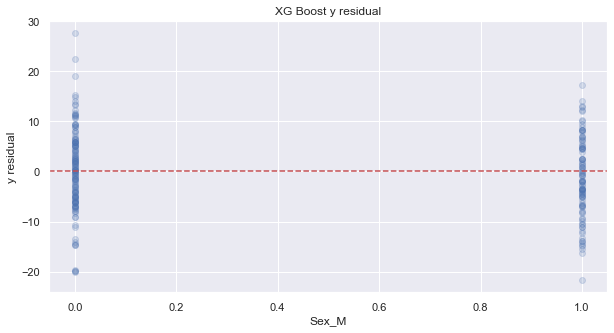

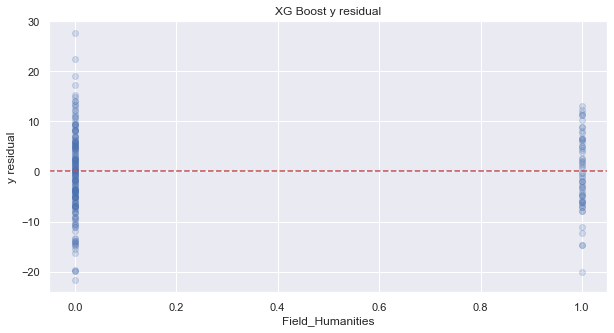

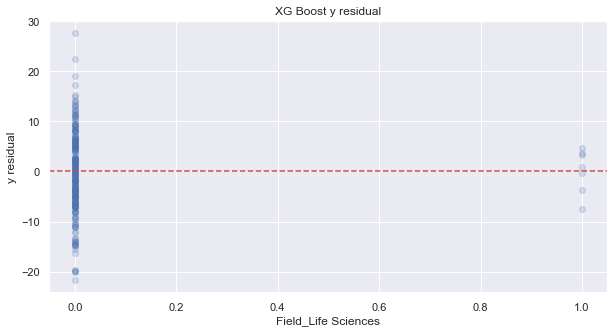

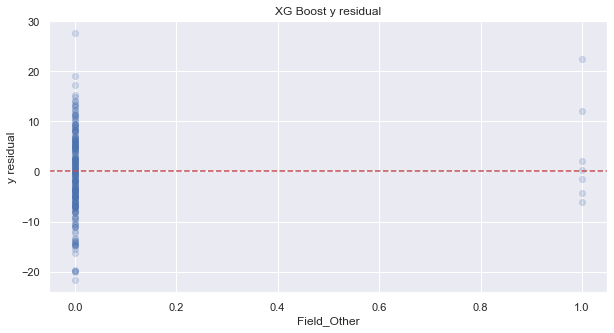

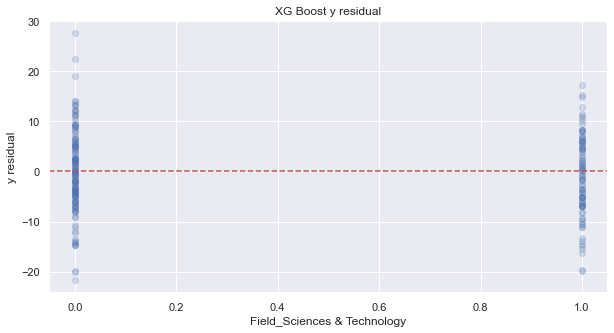

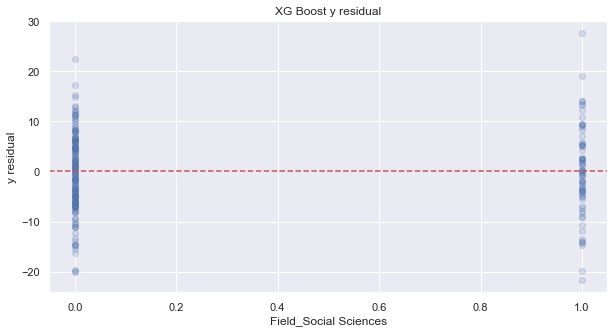

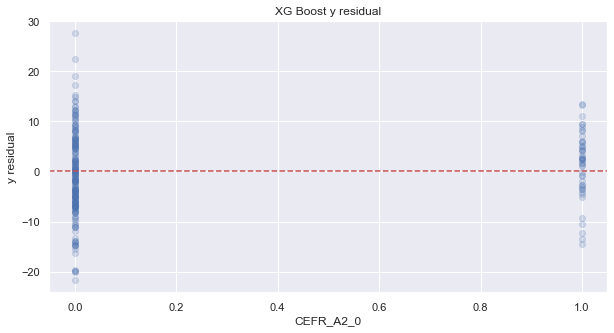

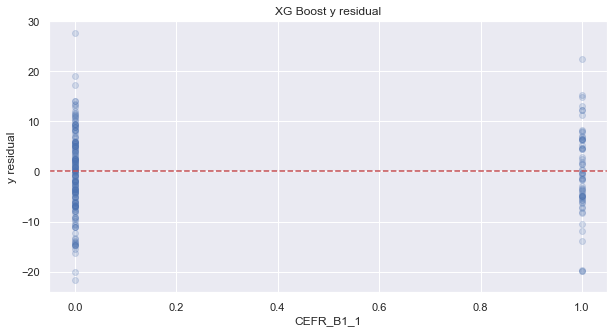

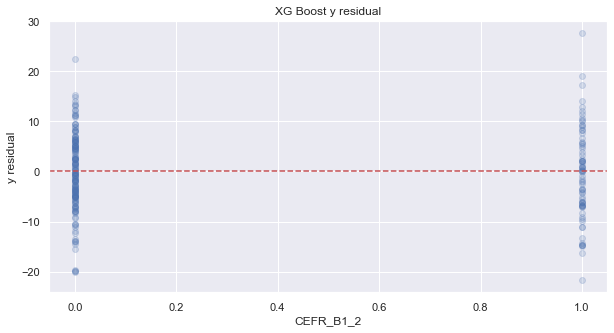

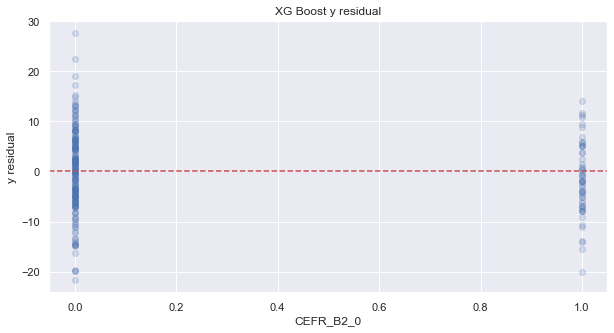

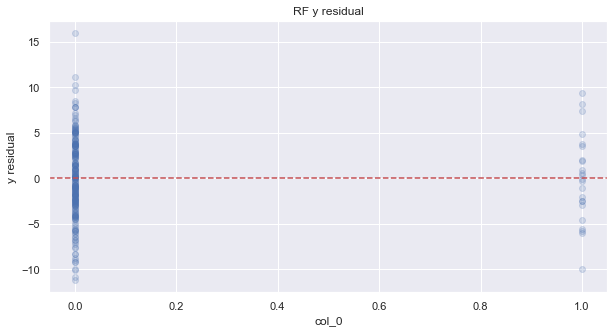

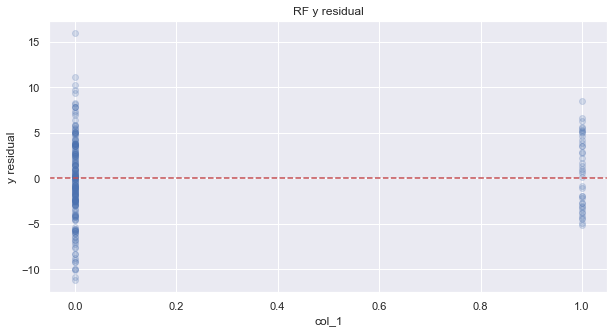

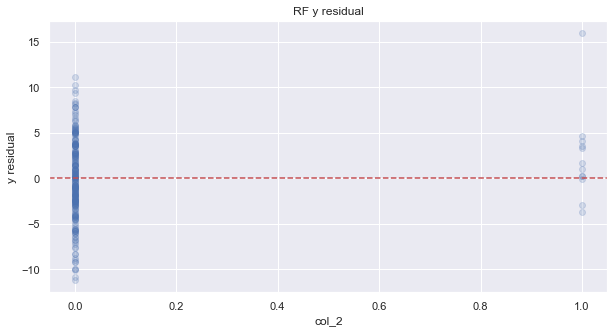

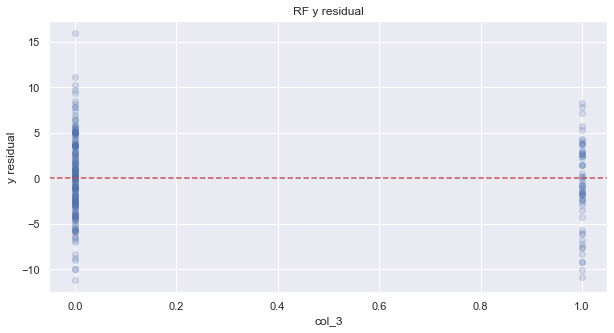

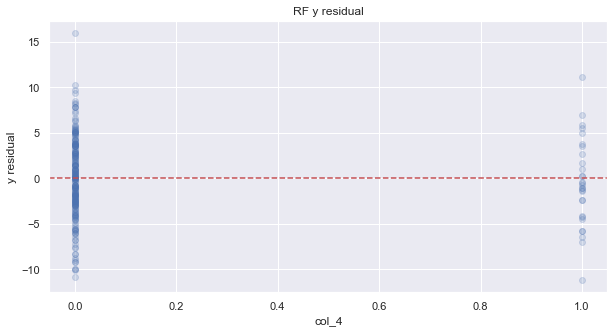

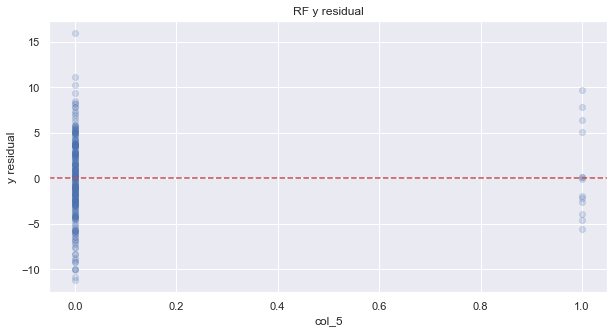

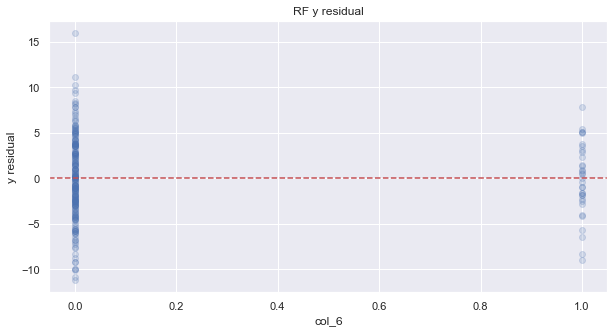

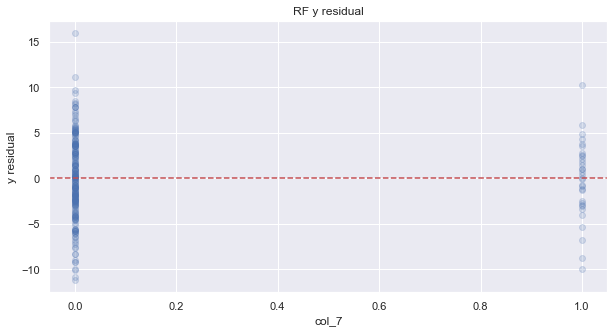

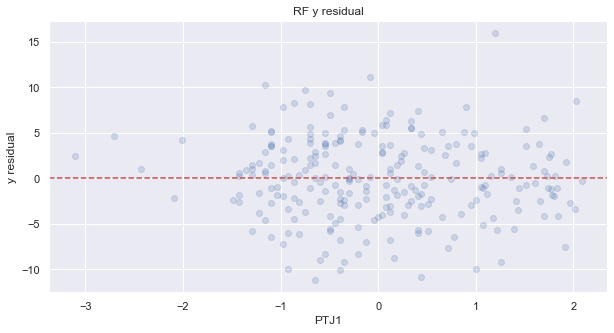

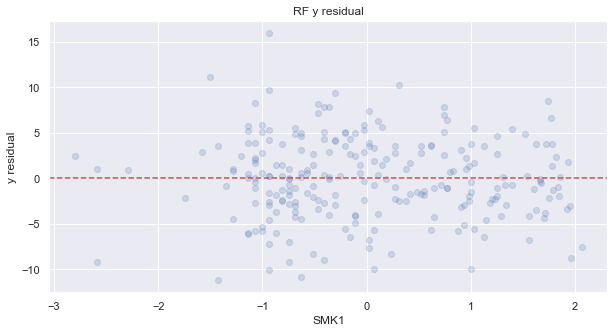

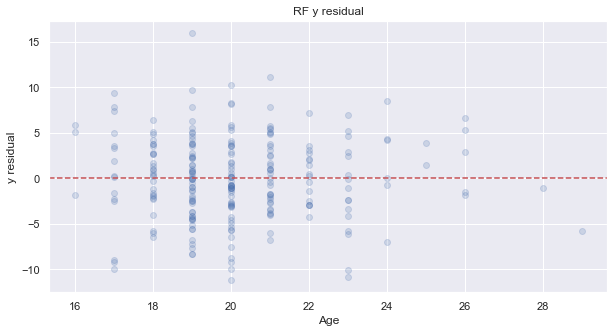

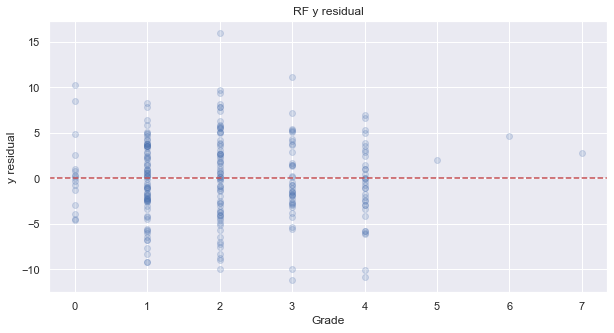

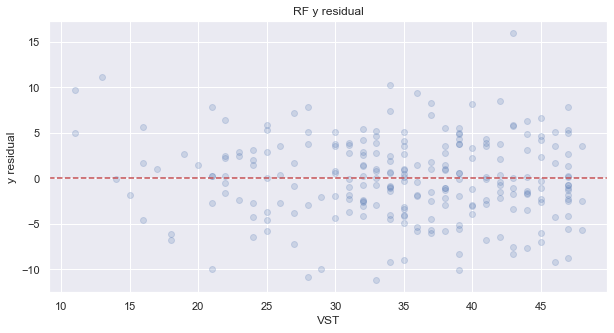

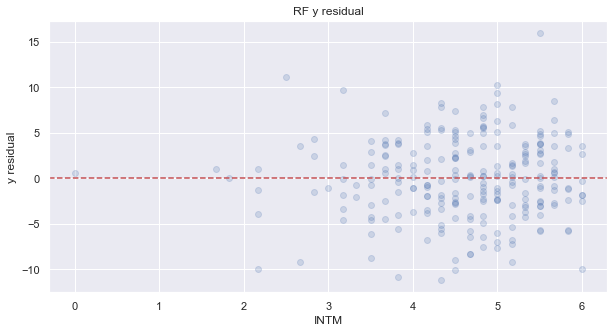

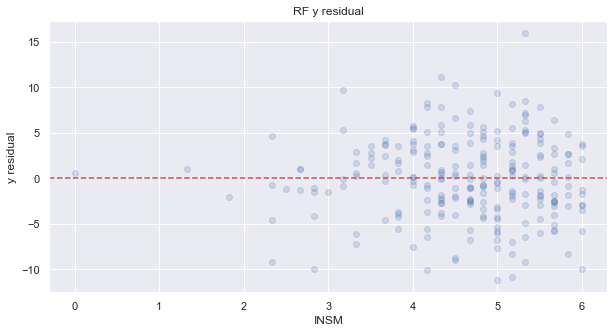

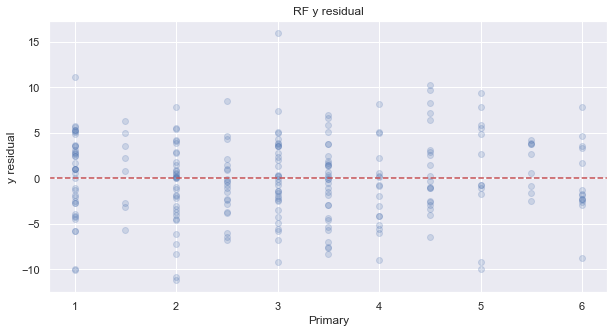

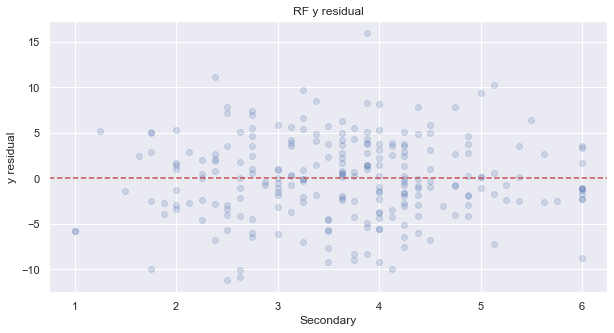

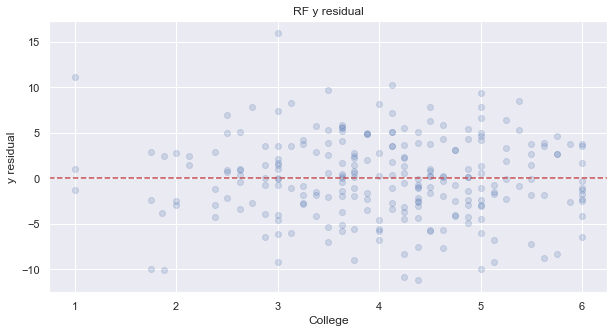

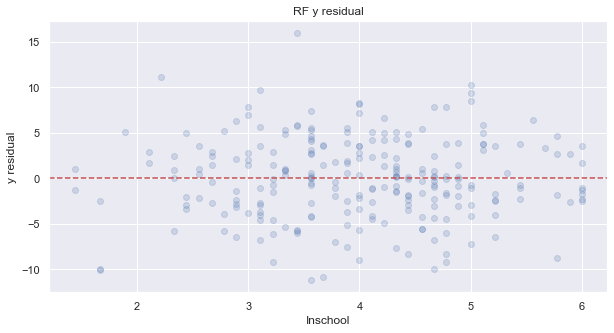

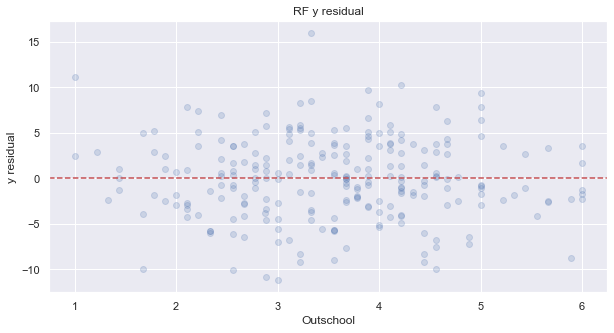

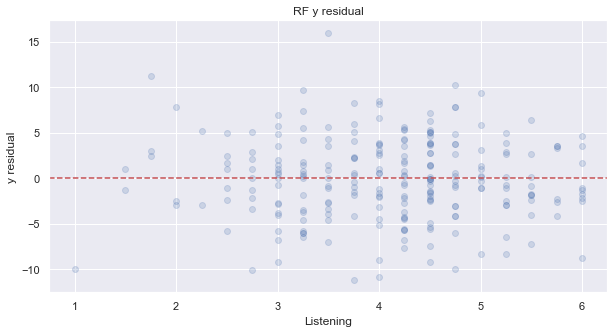

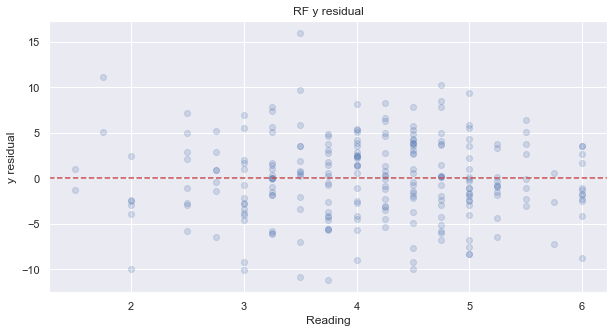

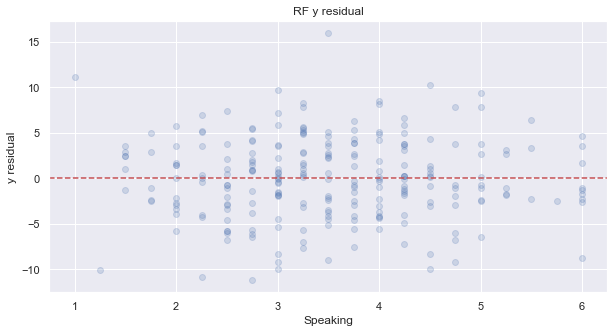

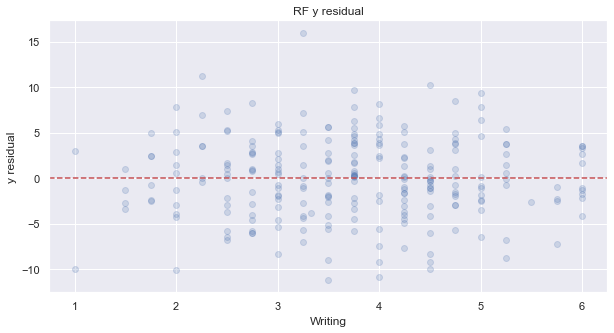

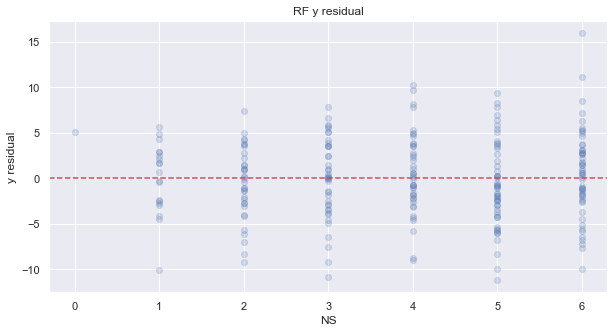

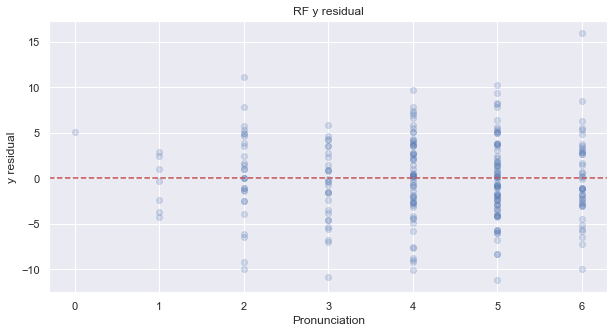

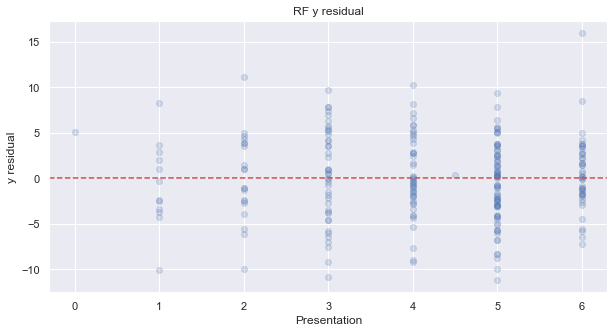

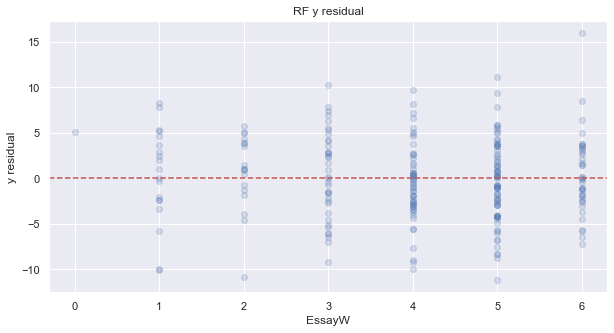

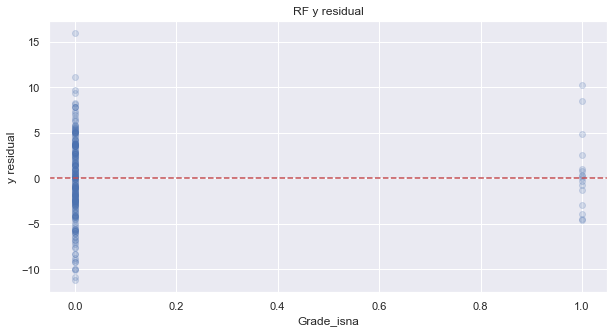

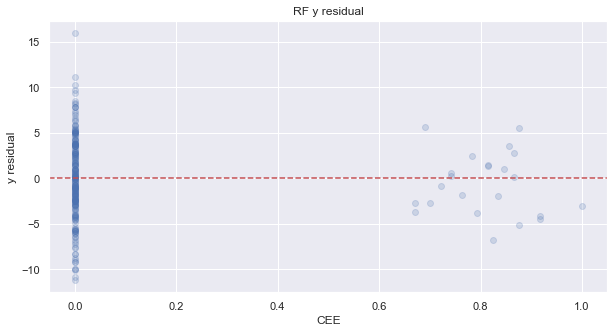

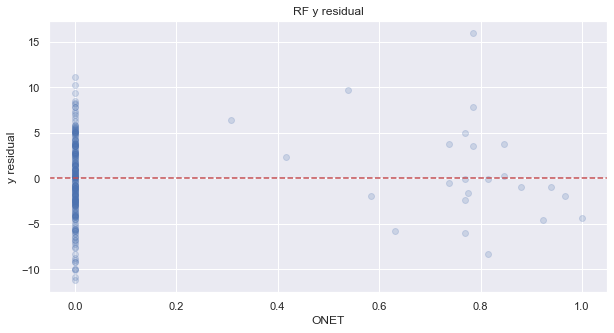

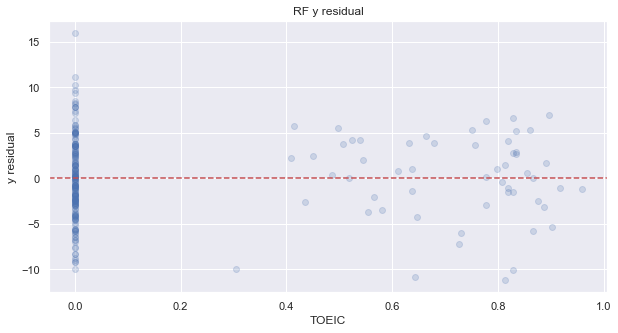

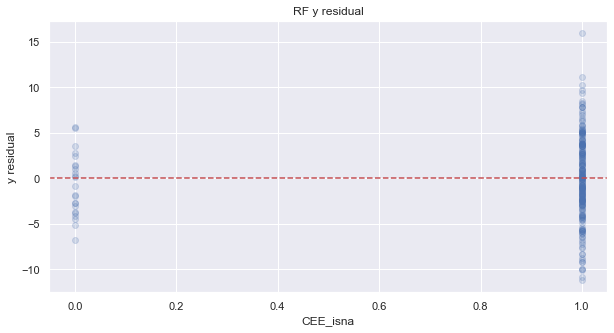

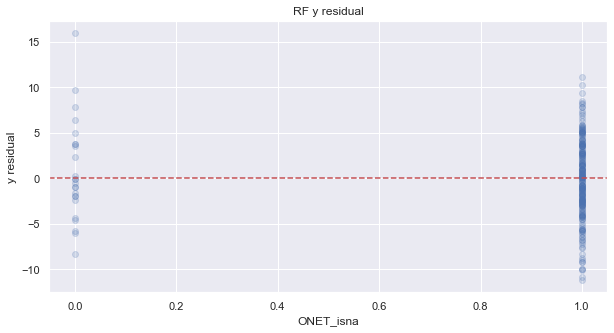

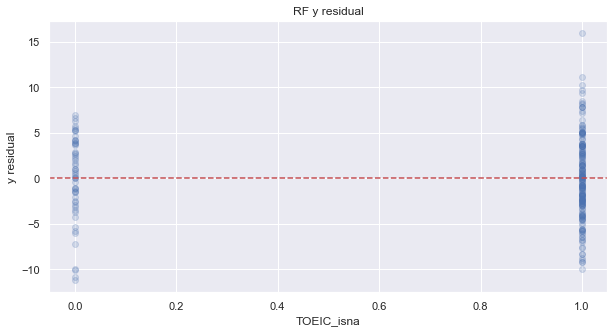

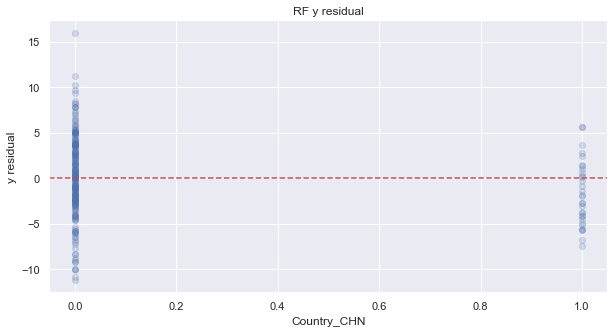

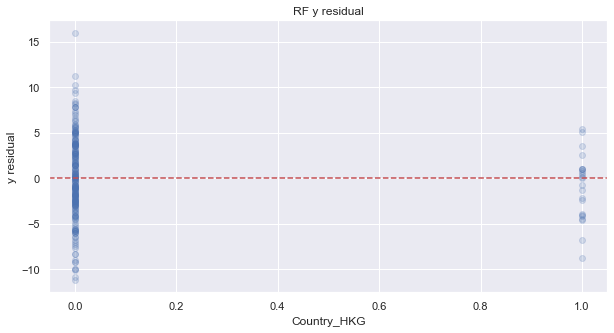

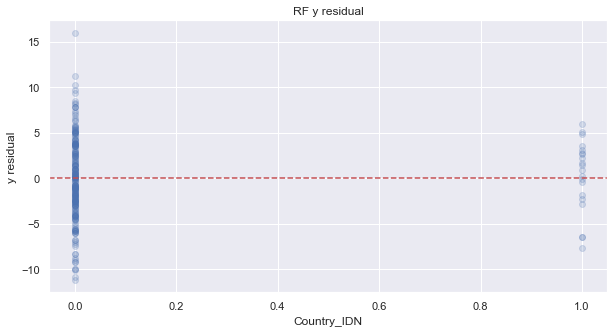

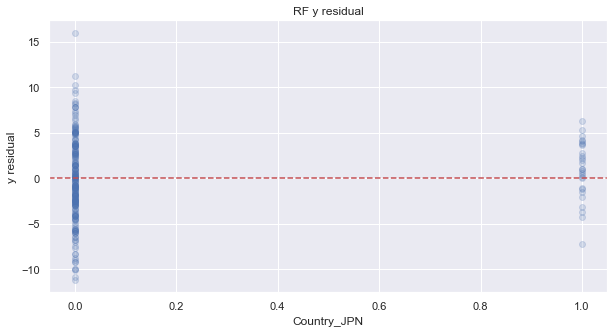

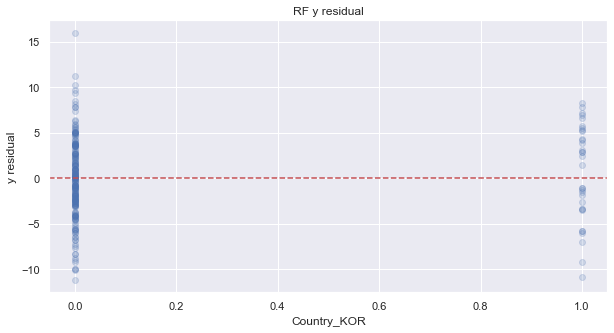

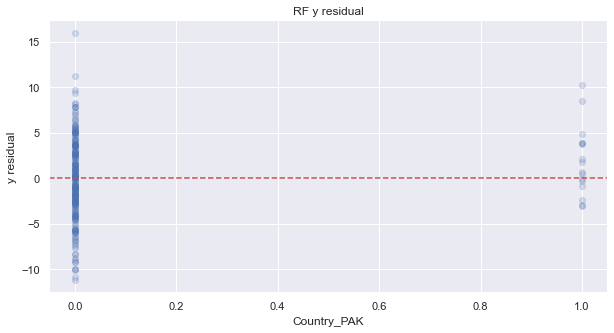

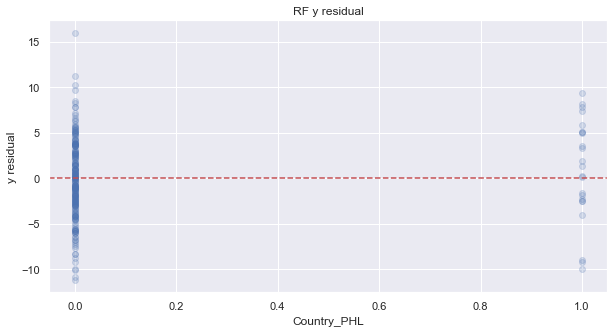

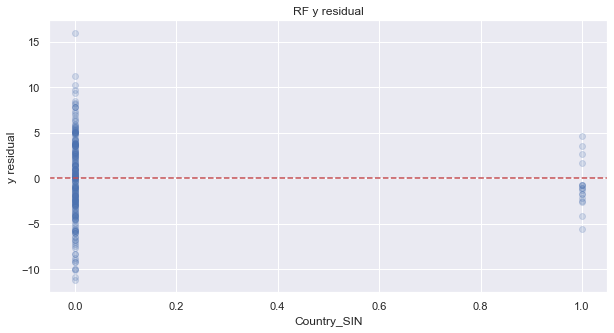

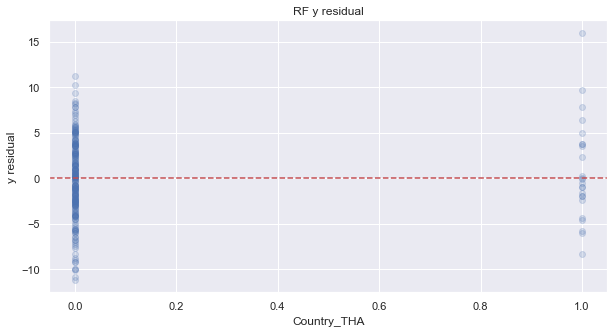

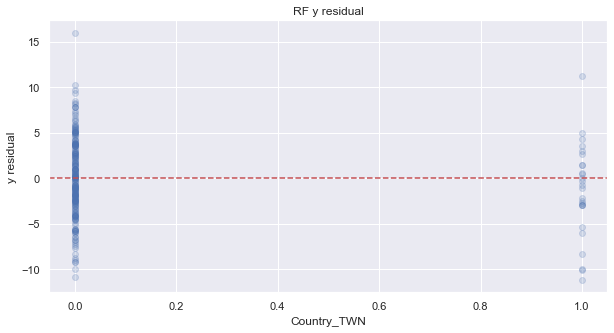

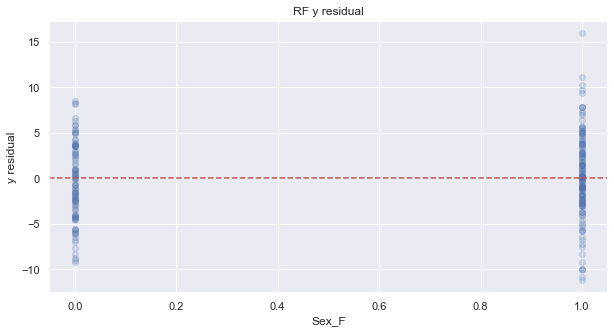

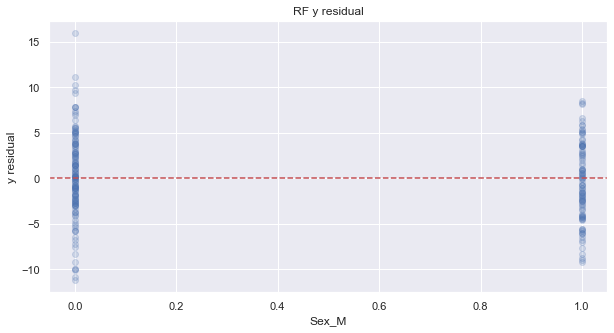

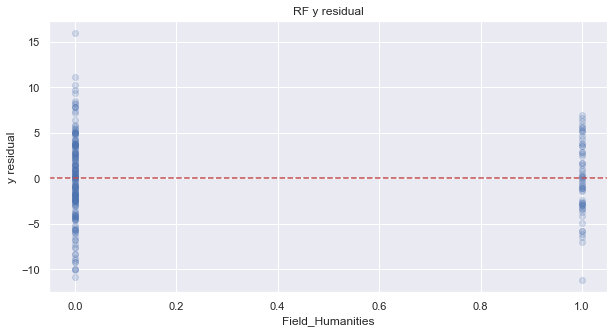

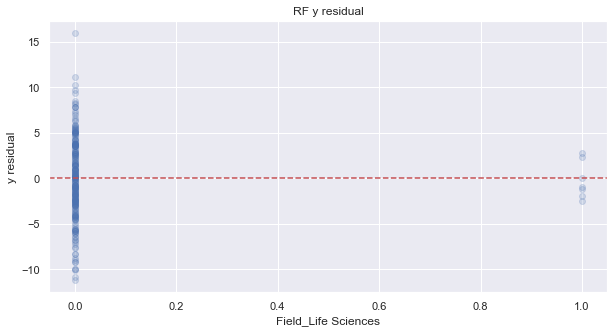

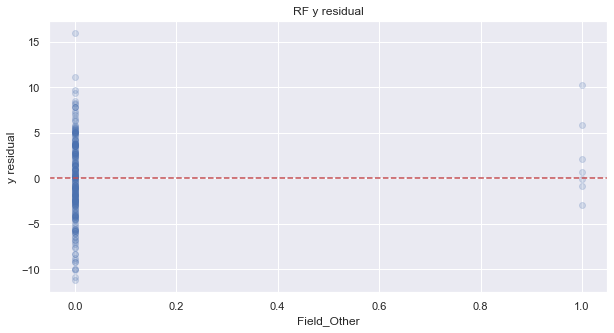

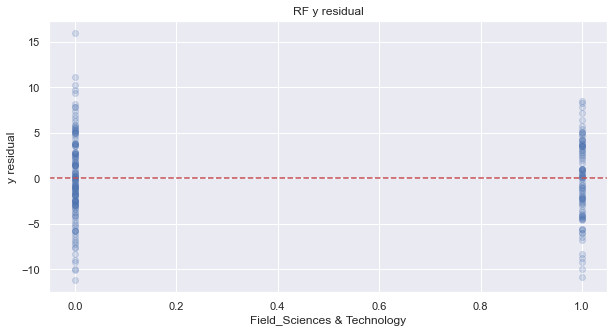

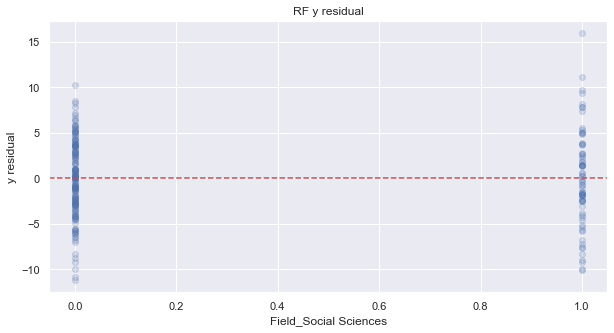

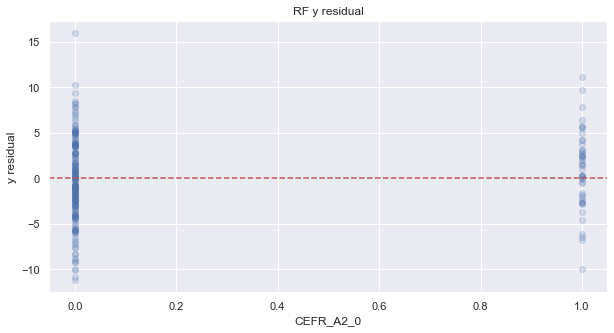

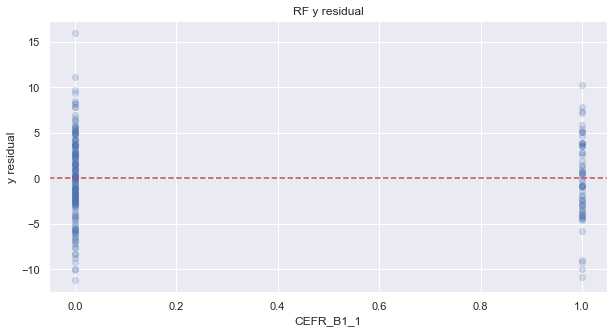

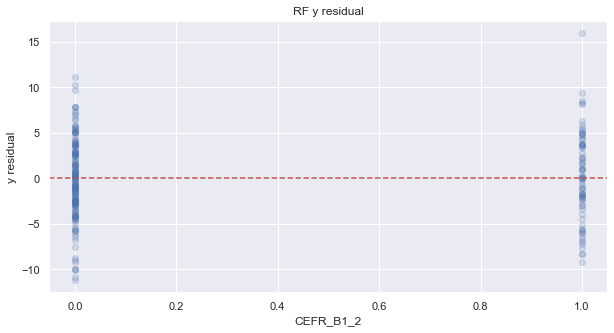

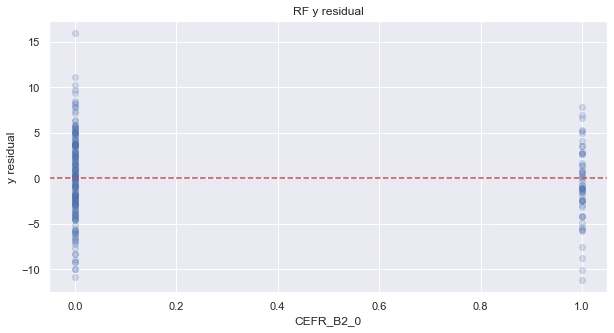

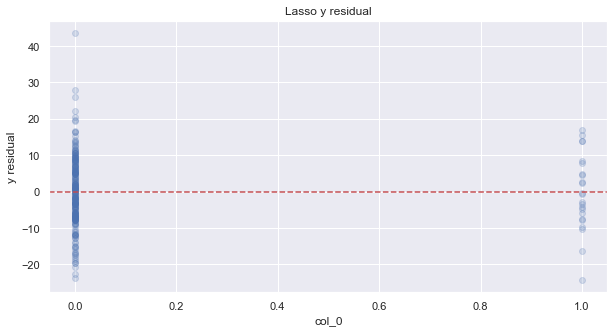

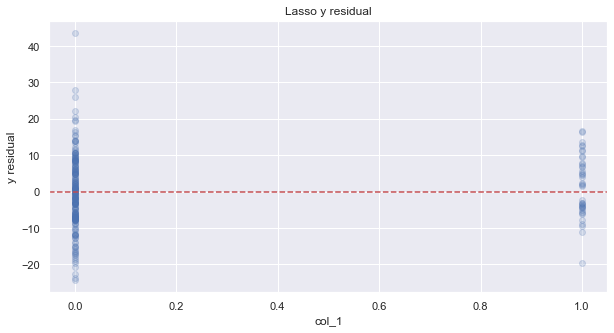

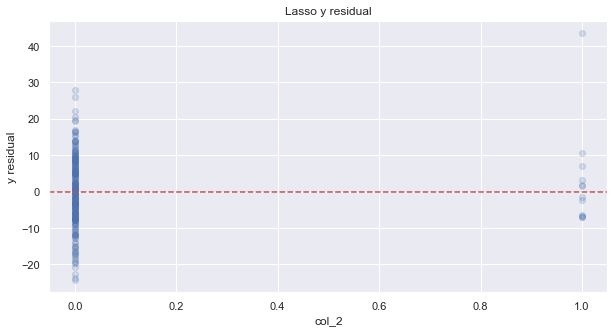

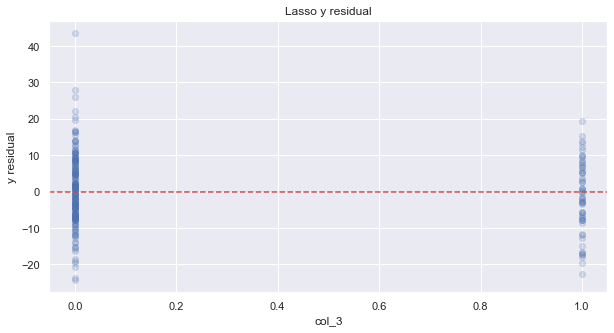

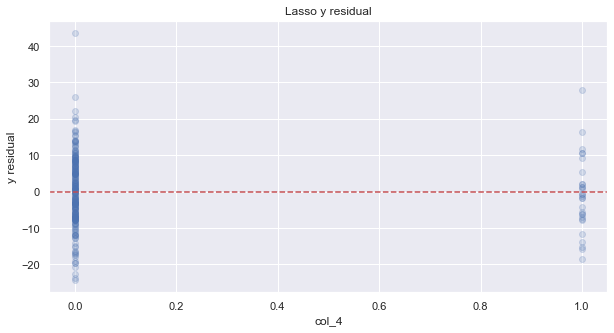

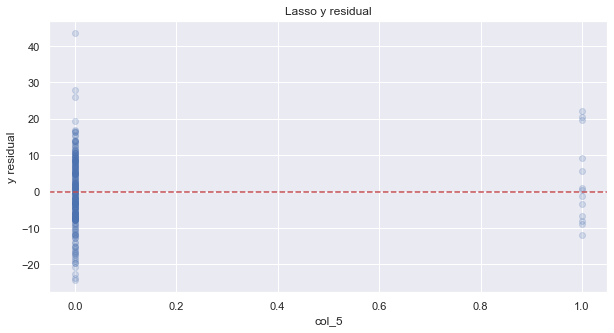

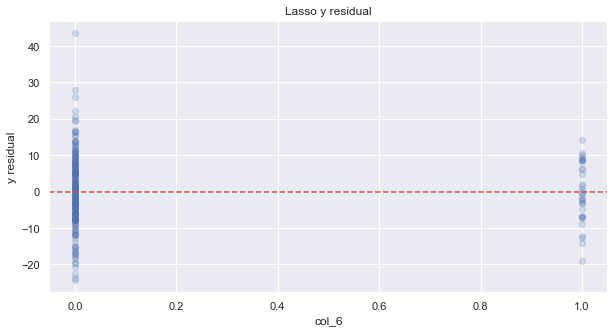

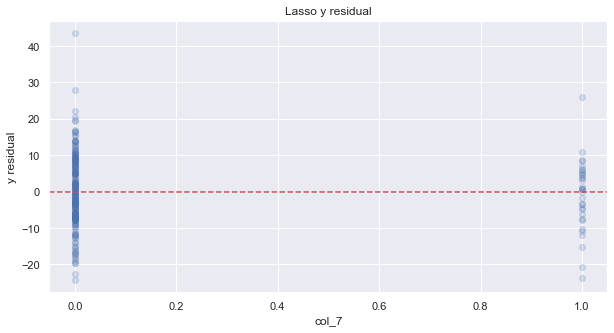

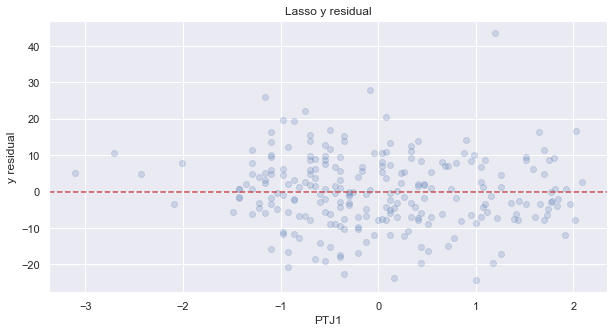

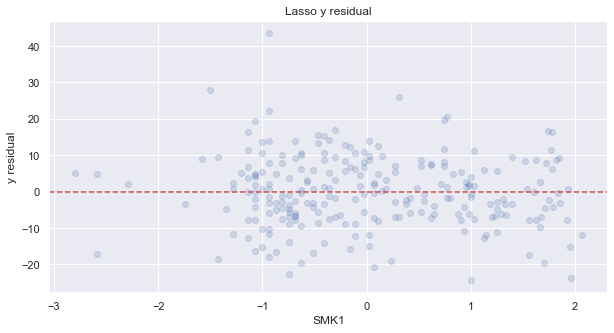

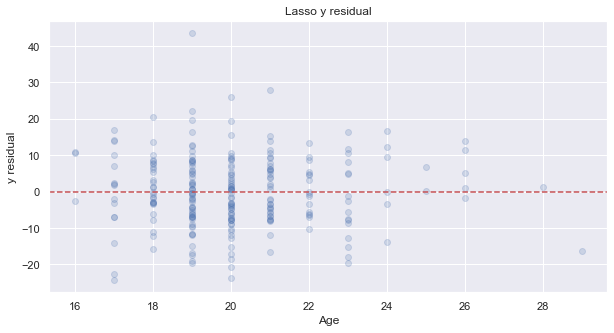

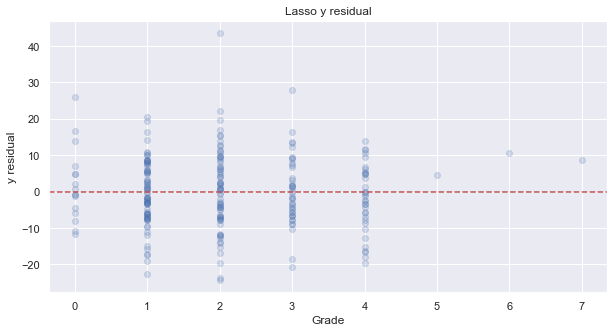

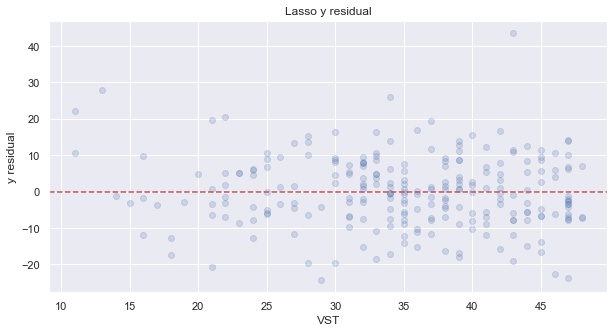

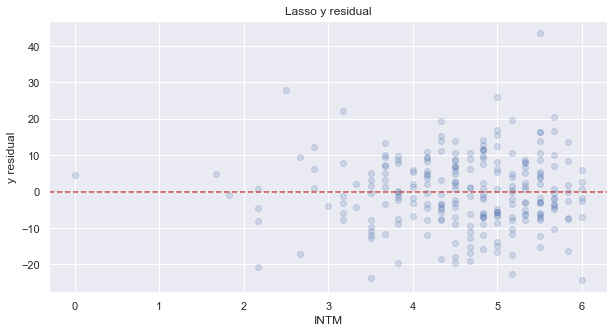

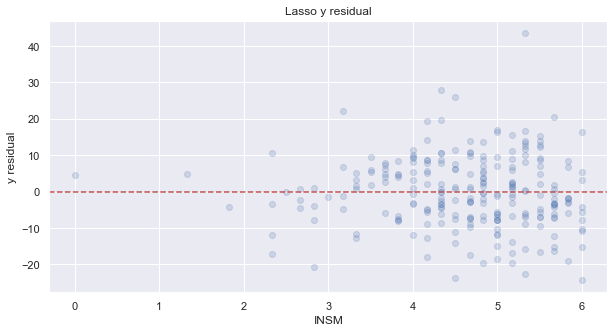

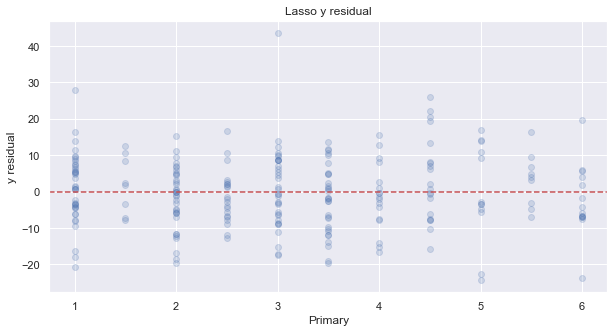

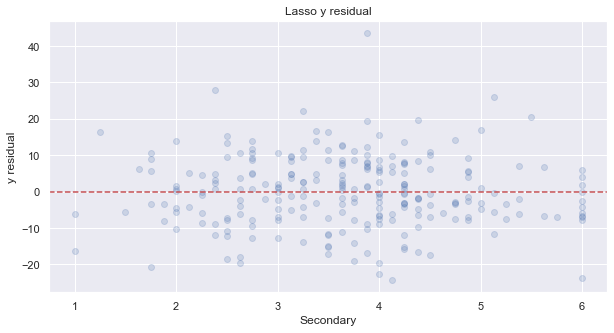

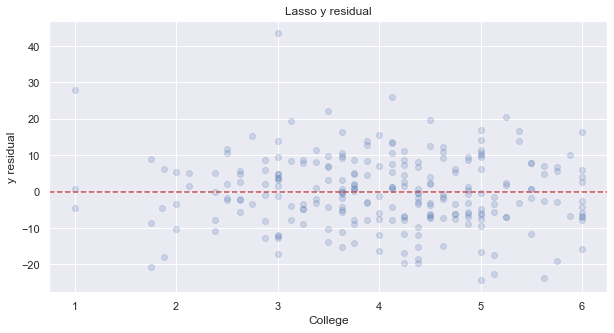

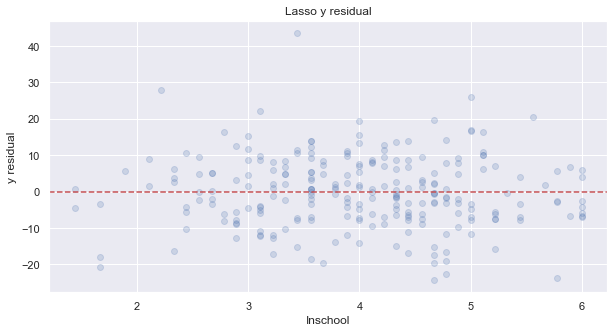

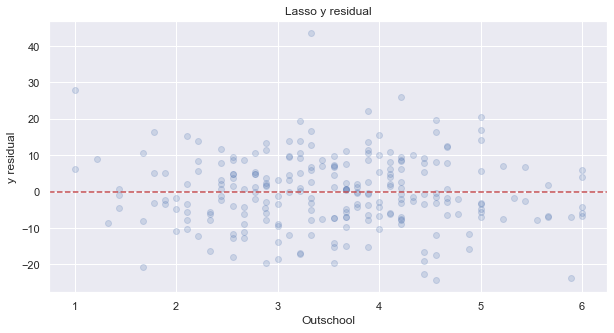

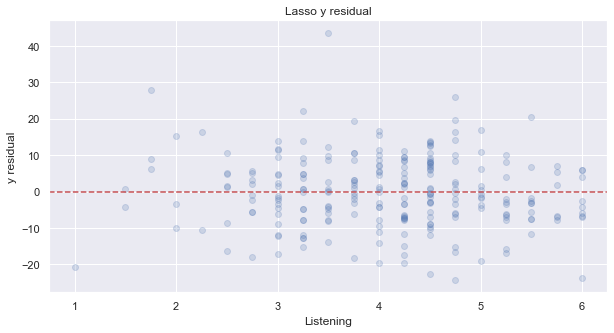

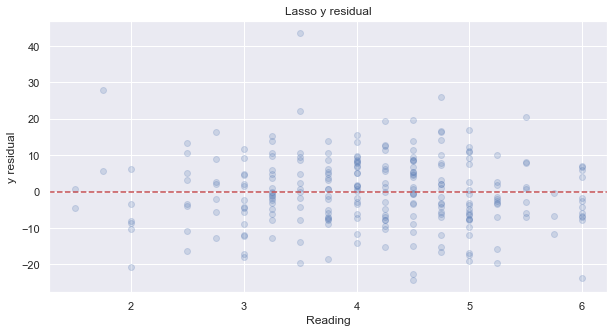

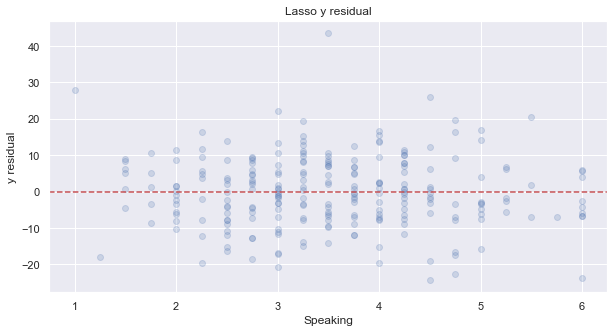

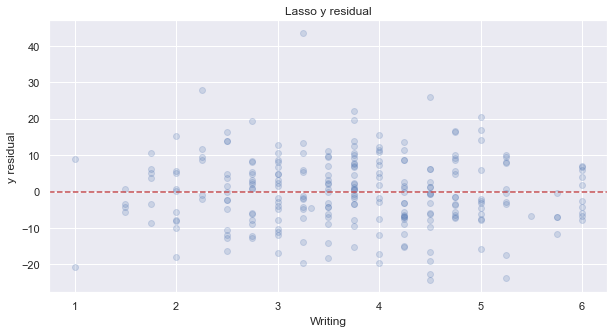

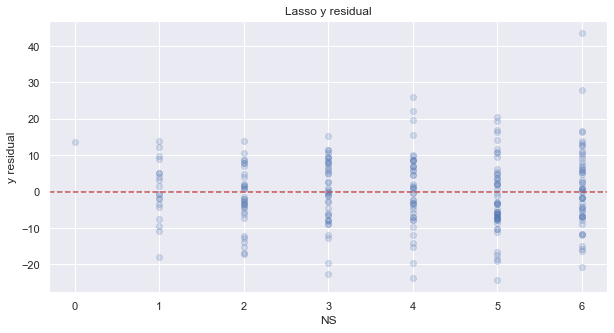

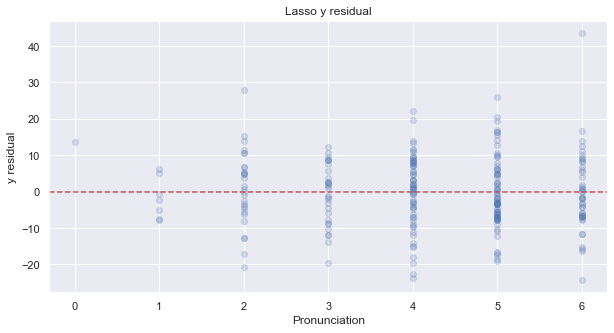

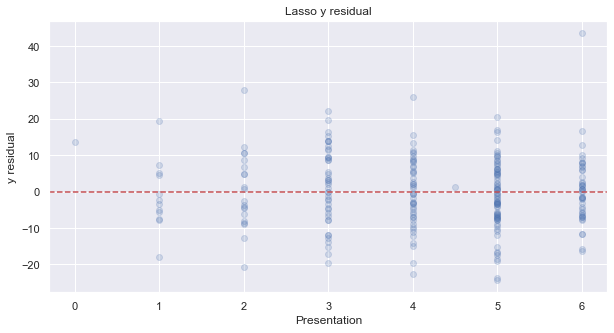

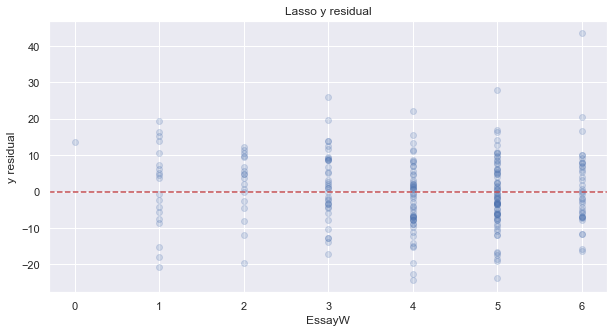

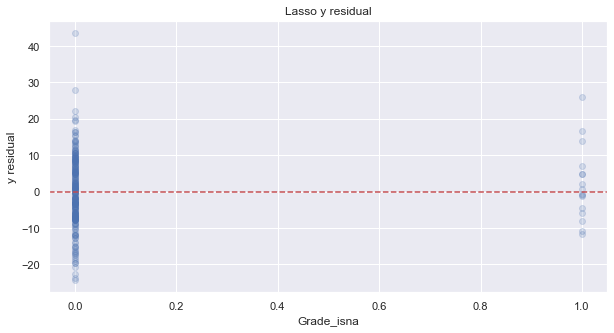

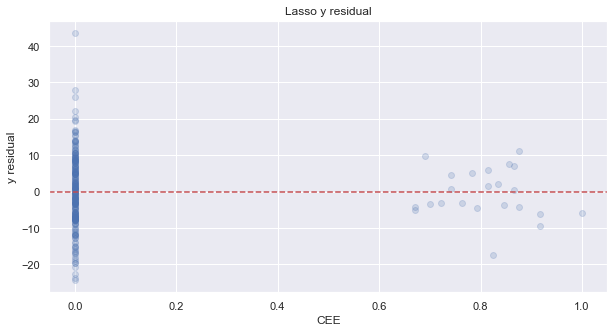

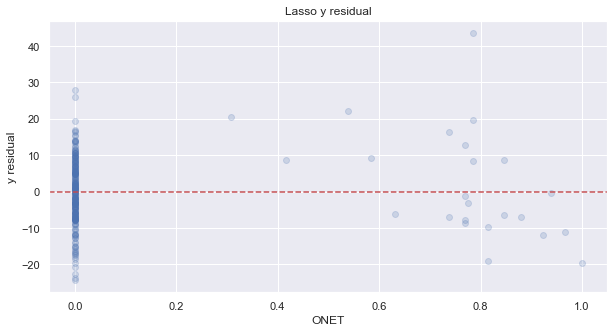

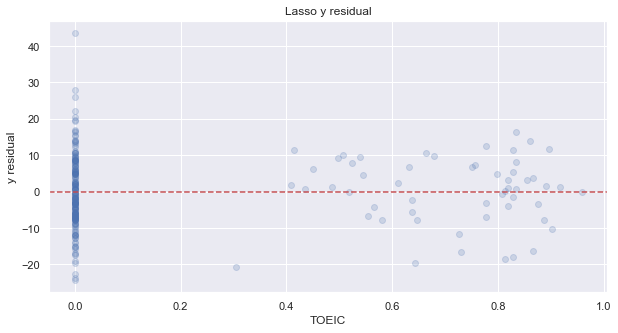

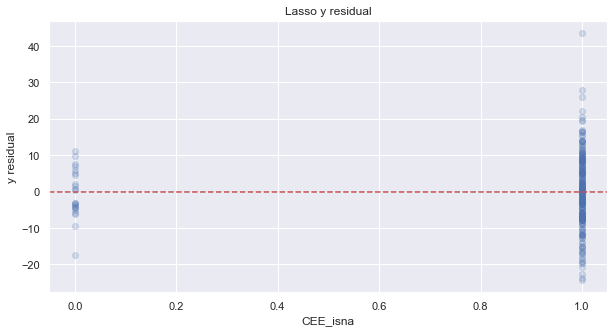

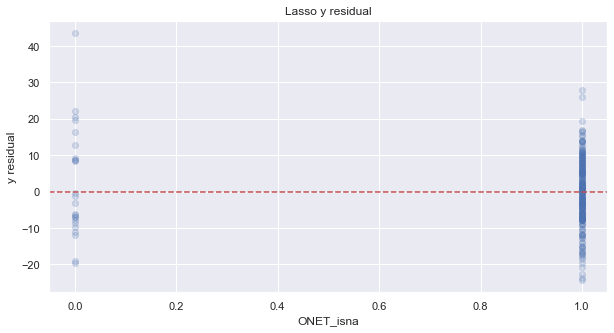

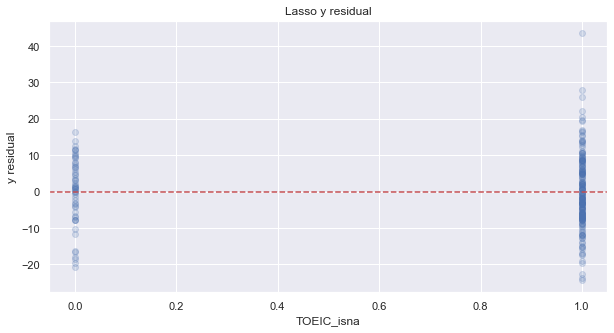

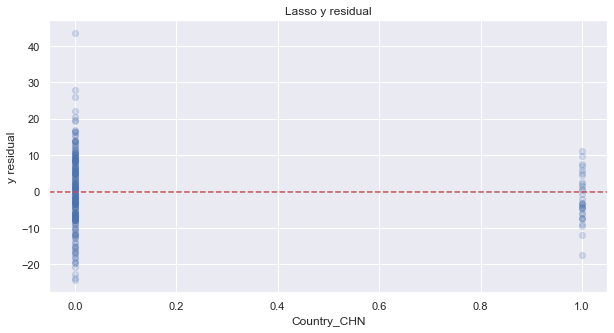

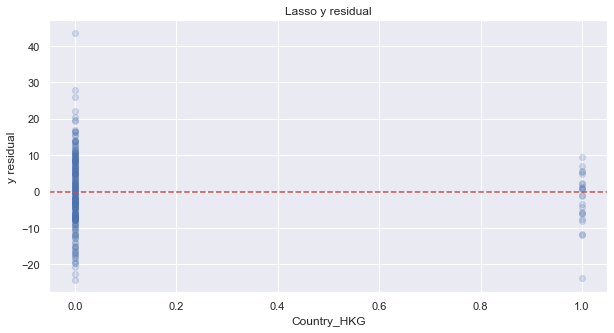

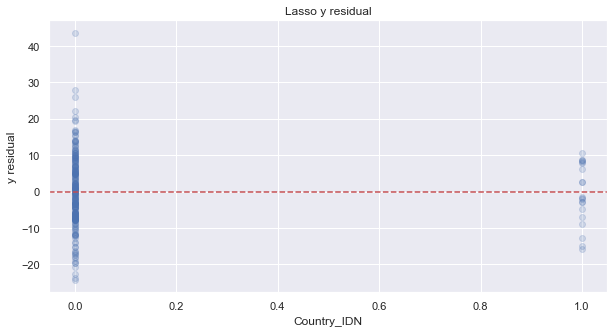

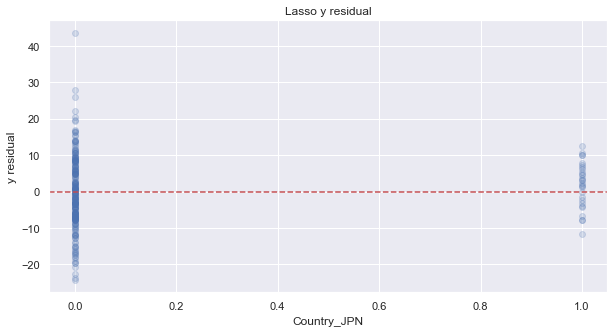

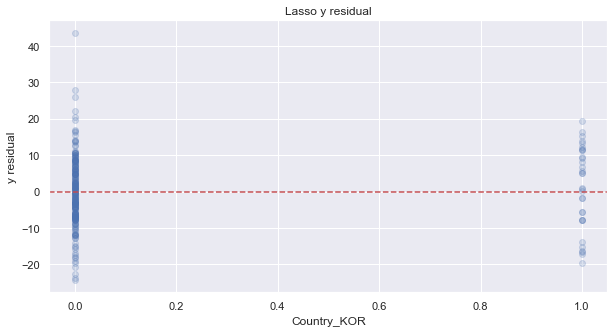

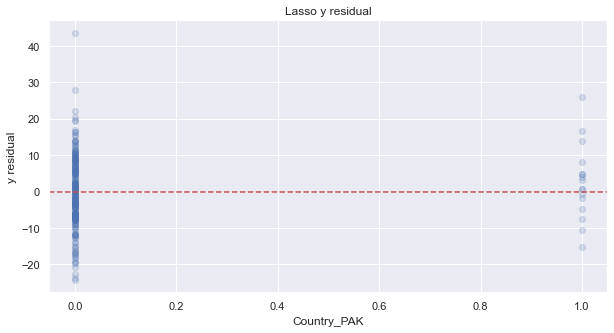

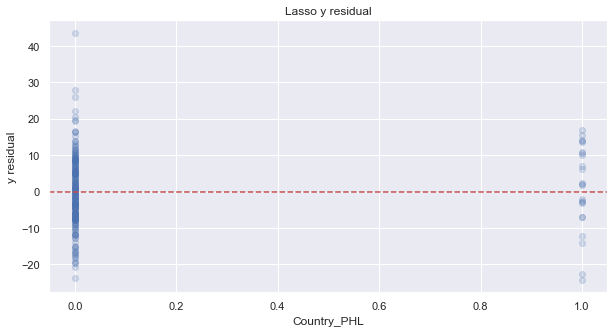

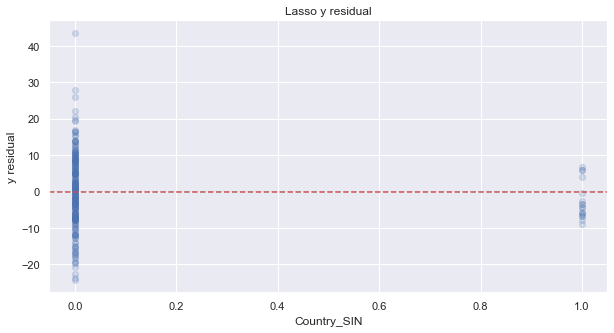

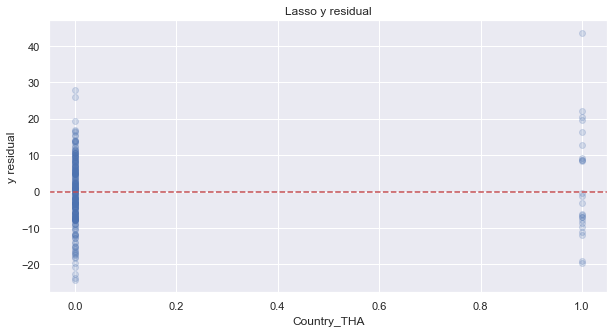

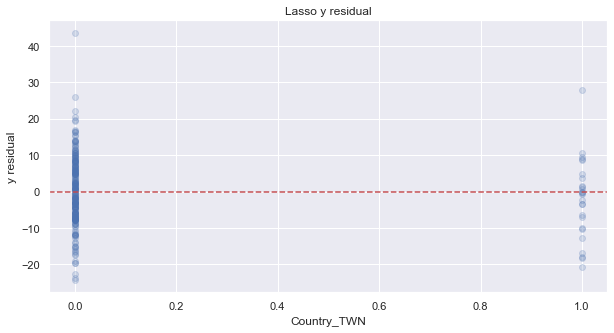

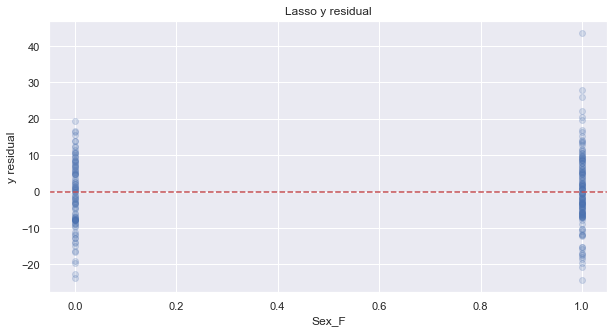

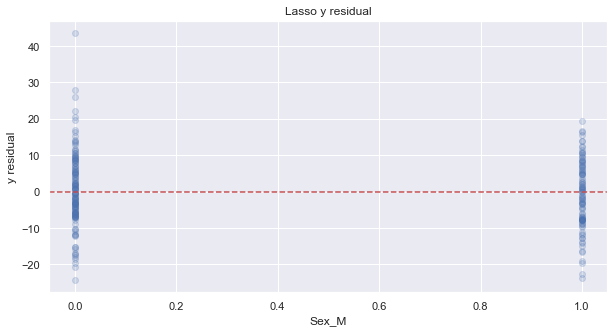

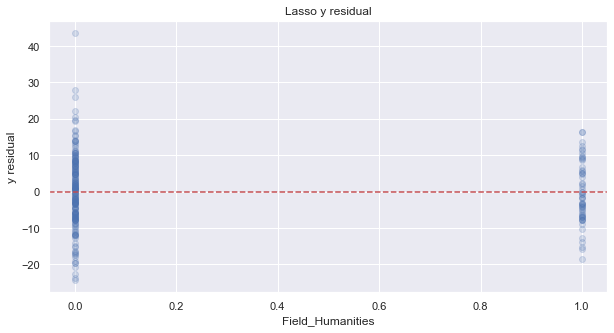

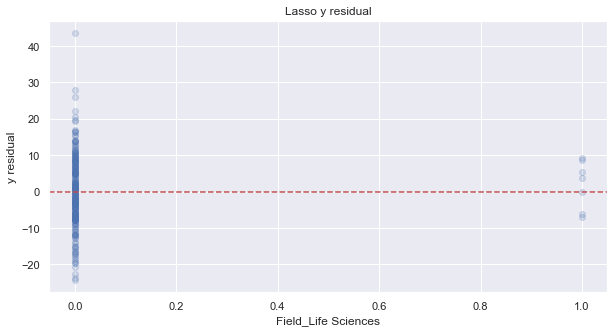

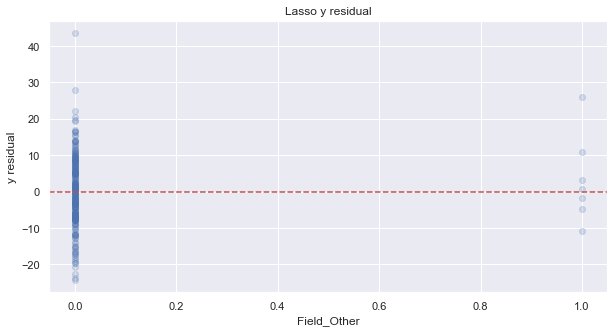

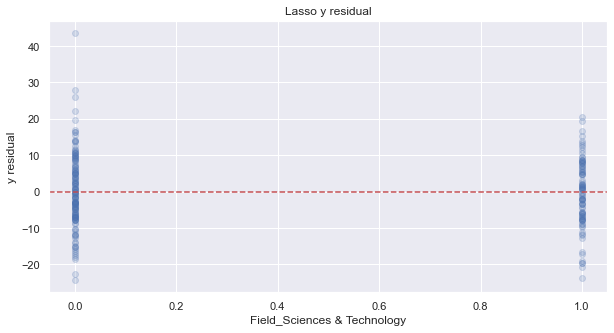

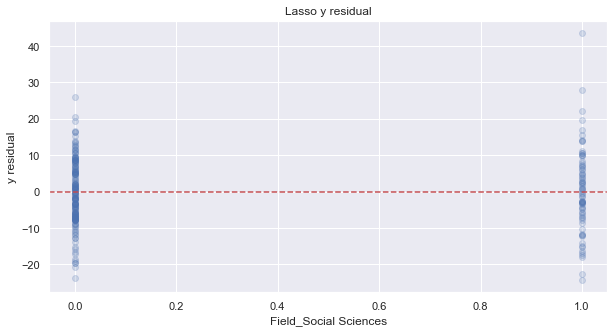

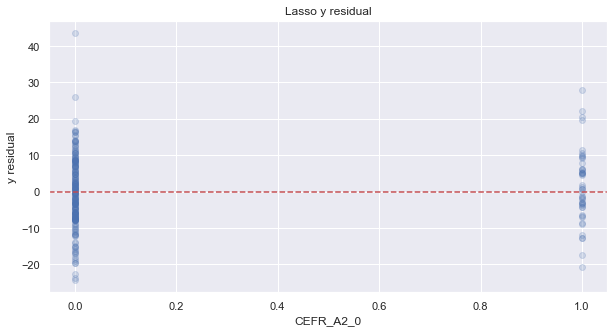

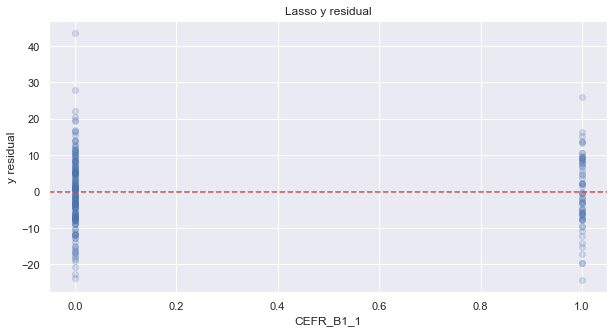

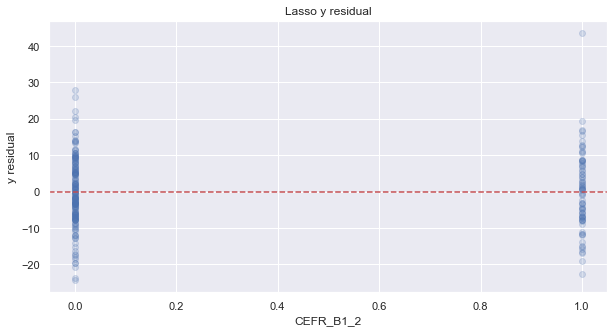

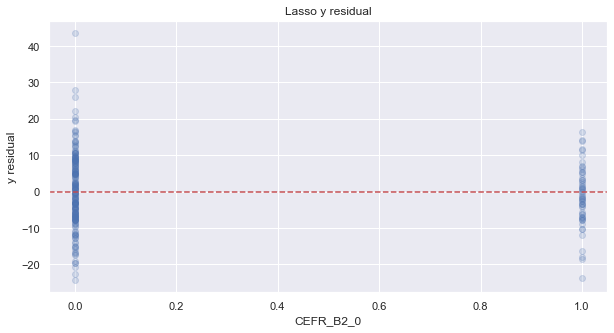

In [94]:
# XG Boost Training prediction residuals
y_tr_xg_res = y_tr_xg_pred - y_train

for c in X_train.columns:
    fig = plt.figure(figsize=(10,5))
    _ = plt.scatter(X_train[c], y_tr_xg_res, alpha=0.2)
    _ = plt.axhline(0, c='r', linestyle='--')
    _ = plt.xlabel(c)
    _ = plt.ylabel('y residual')
    _ = plt.title('XG Boost y residual')
    plt.show()
    
# RF Training prediction residuals
y_tr_rf_res = y_tr_rf_pred - y_train

for c in X_train.columns:
    fig = plt.figure(figsize=(10,5))
    _ = plt.scatter(X_train[c], y_tr_rf_res, alpha=0.2)
    _ = plt.axhline(0, c='r', linestyle='--')
    _ = plt.xlabel(c)
    _ = plt.ylabel('y residual')
    _ = plt.title('RF y residual')
    plt.show()
    
# Lasso Training prediction residuals
y_tr_lasso_res = y_tr_lasso_pred - y_train

for c in X_train.columns:
    fig = plt.figure(figsize=(10,5))
    _ = plt.scatter(X_train[c], y_tr_lasso_res, alpha=0.2)
    _ = plt.axhline(0, c='r', linestyle='--')
    _ = plt.xlabel(c)
    _ = plt.ylabel('y residual')
    _ = plt.title('Lasso y residual')
    plt.show()